### Introduction

In the production of electrical drives, a high product quality is needed. As the industry of electric drive production is confronted by trends such as electric mobility and continuing industrial automation, efficient and flexible processes are needed more than ever. With current quality monitoring technology, accurate quality checking is not feasible. 

Electrical motors mainly consist of the rotor (forgórész), the stator (állórész) and the surrounding housing. The production process can be separated into multiple sub-processes, which can be seen here: '.\img\Intro_dataset.png'. The exact sequence of these steps however depends on the motor type. First, the individual components are manufactured and assembled into subassemblies such as the rotor and the stator. Finally, all components (the housing, the stator, the rotor as well as bearings and end shields) are assembled and the motor is checked in an end-of-line (EOL) test.

This final assembly (összeszerelés, összerakás) is of great importance, as all parts need to be assembled in the correct way, to ensure smooth operation. Therefore, a quality monitoring system is needed, raising alarm if assembly errors are detected. However, especially in lot-size one production, traditional computer vision systems might reach their limits and cannot be used anymore. <br>
'Lot Size One' is the concept of a single item quantity for an order, the exact opposite of mass production.  <br>
Lot size one refers to a small quantity ('one') of goods ordered for delivery on a specific date or manufactured in a single production run. <br>

Thus, in this lab we will build a smart quality monitoring system for the electric drives production. An already existing visual sensor captures images of the electric motor after assembly. These images show the part from the top, as well from the side perspective. It is now the target to decide whether the motor is fully assembled, or whether one of multiple defects is present. There is data from three different defects available: *missing cover*, *missing screw* and *not screwed*. Examples of these defects can be seen below. To achieve this, we will investigate two different machine learning models: *Support Vector Machines* (SVM) and *Convolutional Neural Networks* (CNN).

Further background information can be found in this paper: [Mayr et al., Machine Learning in Electric Motor Production - Potentials, Challenges and Exemplary Applications](https://ieeexplore.ieee.org/document/9011861)



#### Outline
In this lab the problem will be analyzed step-by-step. Now, only images from the top view are used and only two of the three defects, the defects *missing cover* and *missing screw* are considered. Your task will be to follow along, fill out missing gaps, and answer problems throughout the notebook. 

#### Deliverables
For completing this exercise successfully, you need to deliver certain results. Throughout the notebook you will find **questions** that you need to answer, and coding **tasks** where you need to modify existing code or fill in blanks. Answers to the questions need to be added in the prepared *Answer* markdown fields. Coding tasks can be solved by modifying or inserting code in the cells below the task. If needed, you can add extra cells to the notebook, as long as the order of the existing cells remains unchanged. Once you are finished with the lab, you can submit it through the procedure described in the forum.

Example:

>**Question:** What do I do if I am stuck solving this lab?

>**Answer:** Have a look at the forum, maybe some of your peers already experienced similiar issues. Otherwise start a new discussion to get help!


#### Resources
If you are having issues while completing this lab, feel free to post your questions into the forum. Your peers as well as our teaching advisors will screen the forum regularly and answer open questions. This way, the information is available for fellow students encountering the same issues.


In [4]:
# Mount your GDrive - Authentication required - Please follow the instructions
#from google.colab import drive

#from google.colab.patches import cv2_imshow
# eredetileg Google Colab-ban történő tanulásra szánták ezt a Notebook-t,
# tanuláshoz én jobban preferáltam helyi IDE-ben történő feldolgozást (kivéve modellek), így efeletti sor helyett saját:
from cv2 import imshow
# OpenCV library importálása a képek kezeléséhez

import sys, os

#drive.mount('/content/gdrive')

# Change the current working directory

# Depending on your directory, you may want to adjust this
dir_path = r'E:\Gazdinfo\4. félév FAU\tárgyak\MLE\Exercises\DL for Image Classification'
sys.path.append(dir_path)
os.chdir(dir_path)

In [3]:
# As in the previous exercises, we'll import commonly used libraries right at the start
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import tensorflow as tf
# The check.py script contains the quality gates you can use for selftesting throughout the lab
from scripts.check import *

## Steps
To achieve the solution mentioned above, we will execute the following steps in this lab:

1. First, we will code the necessary functions for loading and preprocessing of the data. We will also set up some methods that help us displaying our progress throughout the exercise
2. Second, we will do a short analysis of the existing dataset
3. Afterwards, we will start building our first image classification model using SVMs
4. Once we are familiar and comfortable with SVMs, we will switch to neural networks and try out CNNs
5. Finally, we will introduce data augmentation (növelés) for improvement of our prediction results.



## Section 1.1: Data preprocessing
The data should be located in the folder called *data* on the same level as this script. Within this folder, two subfolders can be found:
- The folder **top** contains the top view of each motor
- The folder **side** contains the side view of each motor

Each motor is uniquely identified by its filename.

In [6]:
# saját, értelmezéshez
lista = [
          [[1, 2, 3], [1, 2, 3]],

          [[1, 2, 3], [1, 2, 3]],

          [[1, 2, 3], [1, 2, 3]],

          [[1, 2, 3], [1, 2, 3]]
        ]


probaarray = np.array(lista)
print(probaarray.ndim)
probaarray.shape

3


(4, 2, 3)

In [7]:
# Loading one image in top view
path = "./data/top/L1_C_3.JPG"
img = cv2.imread(path)

print(img.shape)
print(img)
print(img[0][1][2])
# a 3 dimenzió: width, height, number of channels-színkódok, RGB-nek van red, green and blue channel, a grayscale image has just one channel.

# saját, értelmezéshez
#When working with OpenCV Python, images are stored in numpy ndarray. 
#To get the image shape or size, use ndarray.shape to get the dimensions of the image. 
#Then, you can use index on the dimensions variable to get width, height and number of channels for each pixel. Itt erre gondol:
print("---------------------")
print(img.shape[0]) #width
print(img.shape[1]) #height
print(img.shape[2]) #number of channels (színkódok)

(1024, 1024, 3)
[[[61 42 37]
  [62 45 42]
  [57 39 38]
  ...
  [30 20 20]
  [33 21 19]
  [37 25 23]]

 [[58 39 34]
  [59 40 35]
  [58 41 38]
  ...
  [38 26 26]
  [36 24 22]
  [34 22 20]]

 [[59 42 33]
  [60 42 35]
  [59 43 36]
  ...
  [38 26 24]
  [38 26 24]
  [35 23 21]]

 ...

 [[64 45 37]
  [56 37 29]
  [63 44 36]
  ...
  [48 33 30]
  [46 32 26]
  [46 33 25]]

 [[68 49 42]
  [57 38 31]
  [62 43 35]
  ...
  [49 35 29]
  [45 32 24]
  [44 31 23]]

 [[66 46 41]
  [60 41 34]
  [61 42 35]
  ...
  [47 33 27]
  [41 28 20]
  [43 30 22]]]
42
---------------------
1024
1024
3


With the snippet above, we are able to load the image from the file into a numpy array, while getting its label (itt a felbontására gondol, azaz a shape-je az array-nek) from the folder path the image is in.
To check the type of a python object, you can use the command `type(img)`. It should return *numpy.ndarray*.

In [8]:
type(img)

numpy.ndarray

Next, we want to plot the image. This can be achieved by executing the following cell.

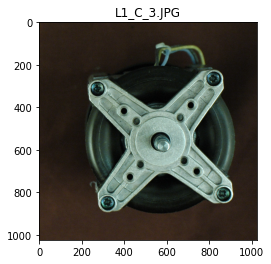

In [9]:
plt.title(path.split(sep= '/') [-1]) # Set the filename as image title 
#separator a /-jel, ez a delimitir (ami mutatja az egységek elejét-végét,
# és a [int] azt jelzi, hogy hányadik ilyen vágás utáni részt írja ki, a -1 az az, hogy összes vágás utánit, tehát az utolsó vágás utáni részt

plt.imshow(img) # Display the image
plt.show()

By default, open cv assumes the images are encoded in blue, green and red. However, the actual order of the color channels is blue, red and green (szerintem elírták, és red green blue, alatta kódban is így van). Thus, the channels need to be converted using `cv2.COLOR_BGR2RGB`.

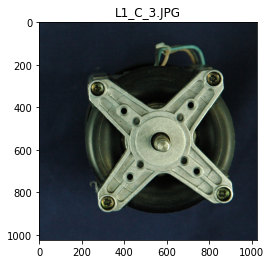

In [10]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert image from bgr to rgb
plt.title(path.split('/')[-1]) # Set the filename as image title
plt.imshow(img) # Display the image
plt.show()

#### Function for loading multiple images
Now it's your turn. For the further analysis, we need to load all the available images from the given data folder *folder*. Besides the image, we need to also find the class of the respective image. The information of the class is encoded in the title of each image. You can use the helper function `get_label_from_name(path)` to parse (felbont) the filename to the class.

>**Task:** Please complete the following function **load_features_labels(folder)**. The function should read the image for a given file, and return two lists:
>- *features* containing all the images as numpy arrays
>- *labels* containing the classes of all images

In [11]:
# saját, értelmezéshez
lista = ["a","b","c"]
for i in lista:
    print(i)

# for ciklusnál az iterátor felveszi a listában lévő elem értékét

a
b
c


In [12]:
import glob

def get_label_from_name(path):
    if "_C_" in path:
        return "Complete"
    if "_MC_" in path:
        return "Missing cover"
    if "_MS_" in path:
        return "Missing screw"
    if "_NS_" in path:
        return "Not screwed"
    return "n/a" # azaz not applicable
    

def load_features_labels(folder, size = (64,32), flatten = True, color = False, identifiers=['NS', 'MS', 'MC', 'C']):
    # size-nak az image_preprocessing-nál van értelme, itt szerintem nincs, de bent hagyom
    # flatten, és color segéd paraméterek, a preprocessing-nál felhasználjuk hogy igazak vagy hamisak-e
    
    features, labels = [], [] # Empty lists for storing the features and labels

    # Iterate over all imagefiles in the given folder
    for file in glob.glob(folder + "/*.JPG"):                       #.glob: Return a list of paths matching a pathname pattern.
                                                                    # tehát az összes file elérési útjából egy listát csinál mint a lista elemei,
                                                                    # és ezen iterál végig
                                                                    # "/*" szerintem a / az elejét jelenti, a * meg hogy bármi
        if any(id in file 
                        for id in identifiers):
            # végig megy az adott (már egy for ciklusban vagyunk) fileneven, és megnézi, hogy benne van-e az id: id in file
            # és az id-t kipróbálja (hogy benne van-e a névben) mindegyik "identifiers" listában lévő elemre,
            # any() bool-t ad vissza, és azt jelenti, hogy bármelyik id benne van-e az adott file nevében

            
            #############################
            # Please add your code here #
            #############################

            img = cv2.imread(file)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
            features.append(img)
            
            labels.append(get_label_from_name(file))

    return features, labels # Return results

    # saját, értelmezéshez
    # Globbing is the process of expanding a non-specific file name containing a wildcard character into 
    # a set of specific file names that exist in storage on a computer, server, or network

If everything works as expected, the function should load 117 features and labels. The execution may take a while.

In [13]:
features, labels = load_features_labels("./data/top")
print("Number of features:", len(features))
print("Number of labels:", len(labels))

# Check data import
quality_gate_111(features, labels)

Number of features: 117
Number of labels: 117


'Quality gate passed :)'

In [14]:
# saját, értelmezéshez
# features: lista, és nem np.array, mert az img = cv2.imread(file) még np.array-t ad vissza, viszont ezt appendeljük a "features" listához
# tehát lista, amely a képeket tartalmazza, és mind a 117 kép egy-egy 1024 x 1024 x 3 -as array-ben van mentve, 
# mert egy képen 1024x1024 pixel van, mindegyik pixel 3 tulajdonsággal
print(type(features))
print(np.array(features).shape)
print(np.array(features)[0].shape)
print(np.array(features).ndim)
print(np.array(features))

<class 'list'>
(117, 1024, 1024, 3)
(1024, 1024, 3)
4
[[[[37 42 61]
   [42 45 62]
   [38 39 57]
   ...
   [20 20 30]
   [19 21 33]
   [23 25 37]]

  [[34 39 58]
   [35 40 59]
   [38 41 58]
   ...
   [26 26 38]
   [22 24 36]
   [20 22 34]]

  [[33 42 59]
   [35 42 60]
   [36 43 59]
   ...
   [24 26 38]
   [24 26 38]
   [21 23 35]]

  ...

  [[37 45 64]
   [29 37 56]
   [36 44 63]
   ...
   [30 33 48]
   [26 32 46]
   [25 33 46]]

  [[42 49 68]
   [31 38 57]
   [35 43 62]
   ...
   [29 35 49]
   [24 32 45]
   [23 31 44]]

  [[41 46 66]
   [34 41 60]
   [35 42 61]
   ...
   [27 33 47]
   [20 28 41]
   [22 30 43]]]


 [[[12 29 45]
   [15 32 48]
   [12 29 45]
   ...
   [18 26 39]
   [19 26 42]
   [20 27 43]]

  [[17 34 50]
   [16 33 49]
   [13 30 46]
   ...
   [15 23 36]
   [14 21 37]
   [17 24 40]]

  [[15 31 47]
   [12 28 44]
   [12 28 44]
   ...
   [14 23 38]
   [10 19 34]
   [14 23 38]]

  ...

  [[18 51 84]
   [25 58 91]
   [24 57 90]
   ...
   [32 61 93]
   [28 54 87]
   [26 52 85]]



In [15]:
# saját, értelmezéshez
# labels: a get_label_from_name(path) segédfüggvény mindegyik filehoz a neve alapján hozzárendel egy stringet, mint labelt
# és ezeket a stringeket appandeltük a "labels" listához
# így ez a lista az egyes képeknek megfelelő 117 labelt tartalmazza 1 dimenzióban, a filenevük-ből meghatározva ezt
print(type(labels))
print(np.array(labels).shape)
print(np.array(labels).ndim)
print(np.array(labels))

<class 'list'>
(117,)
1
['Complete' 'Missing cover' 'Missing cover' 'Missing cover'
 'Missing screw' 'Missing screw' 'Missing screw' 'Missing screw'
 'Missing screw' 'Missing screw' 'Not screwed' 'Not screwed' 'Not screwed'
 'Not screwed' 'Missing cover' 'Missing cover' 'Missing cover'
 'Missing cover' 'Missing cover' 'Missing cover' 'Missing cover'
 'Missing cover' 'Missing cover' 'Missing cover' 'Missing cover'
 'Missing cover' 'Missing cover' 'Missing screw' 'Missing screw'
 'Missing screw' 'Missing screw' 'Missing screw' 'Missing screw'
 'Missing screw' 'Missing screw' 'Missing screw' 'Missing screw'
 'Missing screw' 'Missing screw' 'Missing screw' 'Missing screw'
 'Missing screw' 'Missing screw' 'Missing screw' 'Not screwed'
 'Not screwed' 'Not screwed' 'Not screwed' 'Not screwed' 'Not screwed'
 'Not screwed' 'Not screwed' 'Not screwed' 'Not screwed' 'Not screwed'
 'Not screwed' 'Not screwed' 'Not screwed' 'Not screwed' 'Not screwed'
 'Not screwed' 'Not screwed' 'Not screwed' 'Not

#### Image preprocessing
Before analyzing the images using machine learning, they need to be preprocessed. We will do preprocessing regarding three aspects:
- **Image size**: As the raw images are available in rather high resolution, it might be beneficial to reduce the image resolution. Opencv provides the function `resize()` which works great for that purpose
- **Image color**: In many use cases, the benefit of considering color information might not outway the increased complexity, thus it might be handy to convert the rgb image to bw. This can easily be done using the `cvtColor` function from opencv.
- **Image shape**: Only some algorithms are capable of analyzing the 2.5D structure of image data. For the remaining algorithms, which expect the data to be 1D vector, the image data needs to be flattened from 2.5D to 1D. This can be done using the numpy `reshape` functionality.<br>

szerintem a 2.5D alatt arra gondol, hogy az 1024 (width) x 1024(height) x 3 (number of channels-színkódok) dimenziókból az utolsó az csak félnek számít

In [16]:
def image_preprocessing(img, size = (64,32), flatten = True, color = False):
    # flatten és color True/False segédparaméterek
    
    img = cv2.resize(img, size) # csökkenti a felbontást 64 x 32 pixelre
                                # azaz a képet tároló array-t 64x32x3 -ra formálja át (1024x1024x3-ról)
                                # mivel ez a függvény definiálása (és nem a meghívása), így itt pl az "img" még nem konkrét

    if not color: #ha a (not color) True, azaz ha a color False, akkor RGB-ről grayscale-re konvertáljuk a képek szín dimenzióját
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # itt konvertáljuk a színes képeket grayscale-re, 
                                                    #  azaz a képet tartalmazó array 3. dimenzióját kitöröljük)

    if flatten:
        img = img.reshape(-1) # numpy reshape függvény, az img alapból egy 1024 x 1024 x 3 array (resize-zal és cvtColor-ral már ezen változtattunk)
                              # mert img = cv2.imread(file) -numpy.ndarray-t ad vissza, ezt konvertáljuk 1 dimenziósra
                              # (-1)-gyel nem kell megmondanunk, hogy milyen milyen hosszú legyen az 1. dimenzió, 
                              # hanem az eredeti array hossszából magának kiszámolja, és a megfelelő hosszúságú, 1 dimenziós array-re alakítja
    return img

>**Task:** Please update your `load_features_labels(...)` function from above to do image wise (image szempontjából) data preprocessing using the function `image_preprocessing(...)`. Note that the images shall have the size of 8x8 pixels and be flattened subsequent to the resizing (tehát a kép-arrayek 1 dimenziósra alakítása a felbontás csökkkentése után kell hogy történjen). Therefore be mindful of argument passing between the two functions!

In [17]:
def load_features_labels(folder, size = (64,32), flatten = True, color = False, identifiers=['NS', 'MS', 'MC', 'C']):
    features, labels = [], [] # Empty lists for storing the features and labels
    
    # Iterate over all imagefiles in the given folder
    for file in glob.glob(folder + "/*.JPG"):
        if any(id in file for id in identifiers):
            #############################
            # Please add your code here #
            #############################

            img = cv2.imread(file)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # OpenCV alapból azt hiszi, hogy a színek BGR sorrendbe vannak kódolva, 
                                                       # de közben valójában RGB sorrendbe, ezért át kell konvertálni, hogy a tényleges sorrenddel próbálja megjeleníteni a képet, így tárolja a színkódjait a képnek
                                                       # az image_preprocessing függvény is már RGB-ről alakít grayscale-re

            img = image_preprocessing(img, size=size, flatten=flatten, color=color) # a köré írt függvény paramétereit adjuk át ennek a belső függvénynek
                                                                                    # tehát mikor meghívjuk a külső függvényt, ez a belső függvény a load_features_labels hívásakor megadott paramétereket veszi át
                                                                                    # pl. a size-t a függvény hívásánál változtatja 8x8 pixelre

            # a prepocesselt, azaz kép felbontása 8x8-ra (cv2.resize - size param) -szóval a tároló array 8x8x3-as formájúra alakítása az 1024x1024x3 helyett
            # 1 dimenziósra alakított (.reshape(-1) - flatten param), szürkeárnyalatos (cv2.cvtColor - color param: tároló array 3. dimenziójának törlése)
            # kép-arrayeket fűzzük hozzá a features listához)

            features.append(img)
            labels.append(get_label_from_name(file))

    return features, labels # Return results

In [18]:
################
# Quality gate #
################

features, labels = load_features_labels("./data/top", size=(8, 8), flatten=True, color=False)
quality_gate_112(features, labels)

'Quality gate passed :)'

In [19]:
# saját, értelmezéshez
print(type(features))
print(np.array(features).shape)
print(np.array(features).ndim)
print(np.array(features))

<class 'list'>
(117, 64)
2
[[35 30 27 ... 38 31 34]
 [38 33 32 ... 45 45 42]
 [42 35 34 ... 40 39 38]
 ...
 [37 36 42 ... 15 16 19]
 [49 48 49 ... 32 25 27]
 [61 52 48 ... 16 22 24]]


## Section 1.2: First data analysis
Before diving into machine learning, we'll have a look at the data. With the snippet below you can visualize a sample of the image data available in this lab. It can be observed that the class *missing cover* is rather distinct to the remaining classes, as the large black plastic cover is missing, exposing the copper wires (rézdrótok). The defect *missing screw* is definitely harder to spot as the screws are rather small objects and the color difference between the screw and the empty hole is rather subtle. Finally, the defect *not screwed* can only be seen as some of the screws are not in the shade of the respective hole, thus indicating they are not screwed in all the way.

In [20]:
# saját, értelmezéshez
# enumerate első változója megmondja hogy hányadiknál vagyunk, a második pedig a konkrét értéket veszi fel
values = ["a", "b", "c"]
for i,j in enumerate(values):
    print(i,j)

print("---")
print(4//1)
print(4//2)
print(4//3)
print(4//4)
print(4//5)
print(4//6)

0 a
1 b
2 c
---
4
2
1
1
0
0


0 Axes(0.125,0.125;0.352273x0.755)
1 Axes(0.125,0.125;0.352273x0.755)
2 Axes(0.125,0.125;0.352273x0.755)
3 Axes(0.125,0.125;0.352273x0.755)
4 Axes(0.125,0.125;0.352273x0.755)
5 Axes(0.125,0.125;0.352273x0.755)
6 Axes(0.125,0.125;0.352273x0.755)
7 Axes(0.125,0.125;0.352273x0.755)
8 Axes(0.125,0.125;0.352273x0.755)
9 Axes(0.125,0.125;0.352273x0.755)
10 Axes(0.125,0.125;0.352273x0.755)
11 Axes(0.125,0.125;0.352273x0.755)


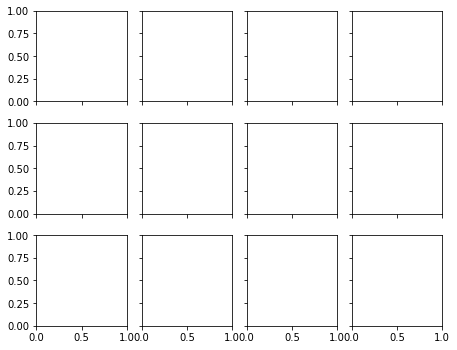

In [21]:
# saját, értelmezéshez
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(16, 12))
grid = ImageGrid(fig, 121, nrows_ncols=(3, 4), axes_pad=(0.2, 0.3))
print(grid)

for i, négyzet in enumerate(grid): 
    print(i, négyzet)


In [22]:
# saját, értelmezéshez
selectedClass = "Missing screw"

featureslistábólarray = np.array(features)
labelslistábólarray = np.array(labels)

print(labelslistábólarray == selectedClass)
print((labelslistábólarray == selectedClass).shape)
print((labelslistábólarray == selectedClass)[4])

count = 0
for j in labelslistábólarray == selectedClass:
    if j == True:
        count = count + 1
        
print(count)
print("-----")

print(featureslistábólarray.shape)
print(featureslistábólarray[labelslistábólarray == selectedClass].shape)
print("-----")

featureslistábólarray[labelslistábólarray == selectedClass]

[False False False False  True  True  True  True  True  True False False
 False False False False False False False False False False False False
 False False False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False  True  True  True
  True  True False False False False False False False False False False
 False False False False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False False False False False False
 False False False False False False False False False]
(117,)
True
42
-----
(117, 64)
(42, 64)
-----


array([[35, 30, 31, ..., 38, 30, 32],
       [33, 32, 36, ..., 43, 38, 34],
       [26, 34, 36, ..., 40, 40, 36],
       ...,
       [48, 46, 54, ..., 15, 21, 22],
       [47, 53, 47, ..., 19, 21, 20],
       [45, 51, 45, ..., 13, 18, 15]], dtype=uint8)

In [23]:
for i in range(12):
    print(i, i//4, i%4)


0 0 0
1 0 1
2 0 2
3 0 3
4 1 0
5 1 1
6 1 2
7 1 3
8 2 0
9 2 1
10 2 2
11 2 3


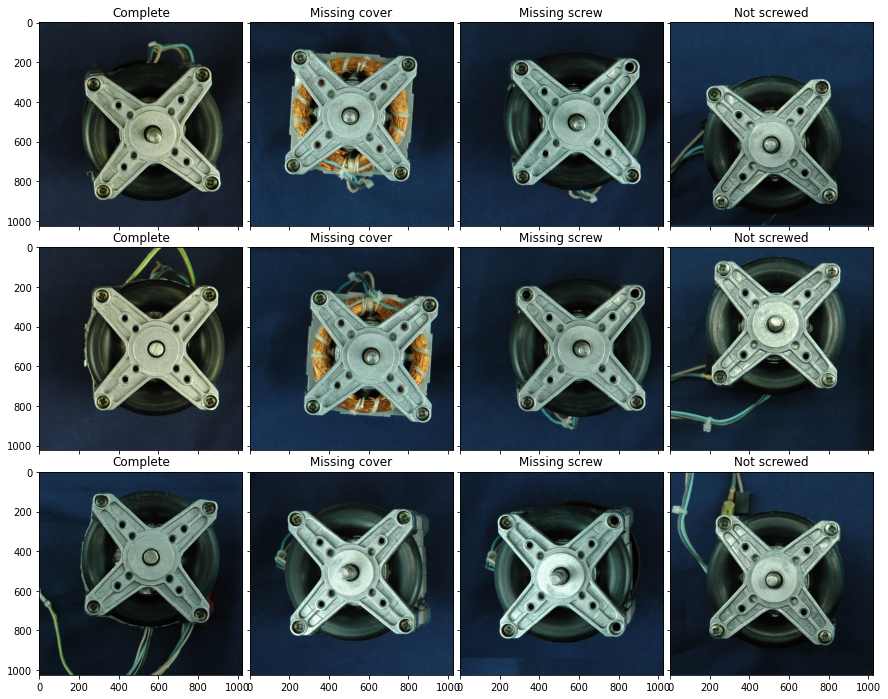

In [24]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(16, 12))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 4), axes_pad=(0.1, 0.3))
# grid: rács 
# fig: the parent figure
# 111: "rect" paraméter: a three-digit subplot position code (e.g., "121"). ha nem 111, akkor pl olyan lesz, mint efelett
# axes_pad: hely a négyzetek között - (horizontal padding, vertical padding) between axes, in inches.


features, labels = load_features_labels("./data/top", size=(1024, 1024), flatten=False, color=True) #mivel most ki akarjuk rajzolni a képeket, 
# nem laposítjuk le 1 dimenzióra a képeket tartalmazó array-eket (flatten), 
# és nem töröljük a színkódokat tartalmazó dimenziót az array-ekből, azaz nem konvertáljuk szürkeárnyalatosra (color)
# (ha 1 dimenzióra laposítanánk, de bent maradna a szín, akkor abban az 1 dimenzióban 3x annyi lenne a pixel)

classes = ['Complete', 'Missing cover', 'Missing screw', 'Not screwed']

featureslistábólarray = np.array(features)
labelslistábólarray = np.array(labels)

for i, négyzet in enumerate(grid):      # i az csak a segédváltozó, ami 0-tól növekedik egyesével 11-ig, mert 3x4 négyzet van
                                   # négyzet pedig mindig az adott négyzetet veszi fel a rácsban(gridben)

    selectedClass = classes[i%4] # Select class  # % értelmezése feletti cellában, itt most minden i-re 0, 1, 2, 3, tehát
                                 # ez itt folyamatosan classes[0/1/2/3], minden i-re változik
        
    images = featureslistábólarray[labelslistábólarray == selectedClass] # Preselect images based on class
    # a for ciklus miatt éppen egy class van kiválasztva,
    # ha egy kép labelje megegyezik ezzel az osztállyal,
    #           <- (==) boolt ad vissza, pontosabban mivel array-hez (labelslistábólarray) hasonlítjuk a stringet (selectedClass), így az array minden egyes elemére megvizsgálja,
    #               hogy egyezik-e az épp kiválasztott osztállyal, és ezáltal egy bool-okat tartalmazó array-t ad vissza
    # akkor ott a == után visszakapott array-ben True az érték, és mivel a 2 array indexelése (elemeik sorrendje) megegyezik, így 
    # pont a megfelelő indexű képek vannak kiválasztva a "featureslistábólarray" array-ből,
    # tehát az images array-ben azokat a képeket tartalmazó 1024x1024x3-as array-ek vannak, azaz feature-k, amelyek megegyeznek a for ciklus osztályával
    
    image = images[i//4] # Select image # i//4: i = 0-3 -> 0, 4-7 -> 1, 8-11 -> 2
    # az images array mindig csak az épp kiválasztott class-nak (i%4-gyel) tartalmazza az összes képét, 
    # és a grid első sorában (i = 0-3) ebből az array-ből a 0 indexű elemet, a második sorban az 1-es indexű elemet, a harmadik sorban pedig a 2-es indexűt válaszjuk ki

    négyzet.imshow(image) # Plot image # a for ciklus által épp kiválasztott elemébben (négyzetében) a gridnek jelenítjük meg az image-t
    négyzet.set_title(selectedClass) # Assign class as image title

plt.show()

First, let's investigate the distribution of the available images among the classes.

>**Task:** Please create a plot showing the distribution of the different classes and discuss the distribution in the field below. 

In [25]:
# saját, értelmezéshez
print(labelslistábólarray.shape)

from collections import Counter

print(Counter(labels)['Missing screw'])

Counter(labels)

(117,)
42


Counter({'Complete': 6,
         'Missing cover': 22,
         'Missing screw': 42,
         'Not screwed': 47})

[6, 22, 42, 47]
<class 'list'>


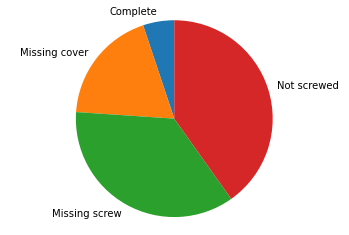

In [26]:
#############################
# Please add your code here #
#############################

label_names = ["Complete", "Missing cover", "Missing screw", "Not screwed"]

eloszlás = Counter(labels)

#values = [eloszlás[label] for label in label_names]
values = [Counter(labels)[label] for label in label_names]
print(values)
print(type(values))

plt.pie(values, labels=label_names, startangle=90)  #startangle: If not None, rotates the start of the pie chart by angle degrees counterclockwise from the x-axis.
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
                   # Tehát hogy a tengelyek ugyanolyan arányúak legyenek
plt.show()


>**Question:** Please discuss the class distribution. Which issues and challenges might appear during model training?

> **Answer**:
Analyzing the labels, we can see that most images represent the defects. Only 6 out of all 117 images represent complete motors. Among the defect classes, not screwed and missing screwed are most present with 47 and 42 classes respective

## Section 1.3: Image classification using Support Vector Machines
In this section, we'll use Support Vector Machines (SVM) to try classifying the image dataset. For SVMs, it is necessary to have the data formatted as 1D vector (ezt flatten=True -val). Also, as mentioned in the description we are only going to consider the three classes *complete*, *missing cover*, and *missing screws*.

In [27]:
features, labels = load_features_labels("./data/top", size=(16,16), color=True, flatten=True, identifiers=['MC', 'MS', 'C'])
print(type(features))
features = np.asarray(features)
labels = np.asarray(labels)

print("Shape of feature vector:", features.shape)
print(features.ndim)

print("Shape of label vector:", labels.shape)
print(labels.ndim)

# a load_features_labels függvénybe bele van írva, hogy csak az "identifiers" listában lévő kategóriákból válasszon,
#   és az 'NS' most nincs ott, ezért nem 117, hanem csak 70 db kép, azaz most vektor van
# 768 = 16 x 16 x 3 pixelesek a képek, minden képet egy-egy 1 dimenziós, 768 hosszúságú array-ben tárol

print(features)
print(labels)

<class 'list'>
Shape of feature vector: (70, 768)
2
Shape of label vector: (70,)
1
[[26 35 48 ... 27 33 49]
 [16 33 54 ... 21 47 77]
 [18 38 62 ... 22 40 68]
 ...
 [27 52 81 ... 14 23 31]
 [24 52 84 ... 14 20 30]
 [29 63 95 ... 13 19 27]]
['Complete' 'Missing cover' 'Missing cover' 'Missing cover'
 'Missing screw' 'Missing screw' 'Missing screw' 'Missing screw'
 'Missing screw' 'Missing screw' 'Missing cover' 'Missing cover'
 'Missing cover' 'Missing cover' 'Missing cover' 'Missing cover'
 'Missing cover' 'Missing cover' 'Missing cover' 'Missing cover'
 'Missing cover' 'Missing cover' 'Missing cover' 'Missing screw'
 'Missing screw' 'Missing screw' 'Missing screw' 'Missing screw'
 'Missing screw' 'Missing screw' 'Missing screw' 'Missing screw'
 'Missing screw' 'Missing screw' 'Missing screw' 'Missing screw'
 'Missing screw' 'Missing screw' 'Missing screw' 'Missing screw'
 'Complete' 'Missing cover' 'Missing screw' 'Missing screw'
 'Missing screw' 'Missing screw' 'Missing screw' 'Comple

In [28]:
# saját, értelmezéshez
#nsarray vs array:
# Same: both array and asarray can convert arrays into ndarray objects
# Difference: When the parameter is a general array, 
# the results of the two functions are the same; when the parameter itself is of the ndarray type, 
# array will create a new ndarray object as a copy of the parameter, 
# but asarray will not be created, but will share the same memory with the parameter.

As we can see, we still load our 117 images -NEM, A 117-ből CSAK 70-t TÖLTÜNK BE MOST, MERT AZ EGYIK CLASS-T KIHAGYTUK, but the pixel values are now simply reshaped to 1D.
Next, we need to separate our data into training and testing datasets. This can be achieved using the `train_test_split()` function from sklearn. You can find the documentation here: [Link](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). 

>**Task:** Fill in the following code so that 70% of the data is used for training, and the remaining 30% for testing. Also, the datasets should be stratified (rétegezve) by the label vector.

In [29]:
from sklearn.model_selection import train_test_split
######################################
# Please complete the following line #a
######################################

X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size = 0.7, stratify=labels, random_state=42)

################
# Quality gate #
################

print(quality_gate_13(X_train, X_test))


# saját, értelmezéshez
print(X_train.shape)
print(X_train.shape[0]) # 1. dimenzió shape-je
print(X_train[48].shape) # X_train array-en belüli 49. array (49 van összesen) shape-je
# 49 a 70%-a a 70-nek, tehát jó
print(X_train)
print(X_test.shape)

print("-----")
print(X_test.shape)
print("-----")

print(y_train.shape)
print(y_train.shape[0])
print(y_train[0])
print(y_test.shape)

Quality gate passed :)
(49, 768)
49
(768,)
[[24 53 80 ... 13 27 36]
 [38 67 96 ... 18 27 39]
 [25 44 70 ... 21 31 46]
 ...
 [14 31 47 ... 10 17 23]
 [33 59 95 ... 13 22 36]
 [20 37 59 ... 18 35 57]]
(21, 768)
-----
(21, 768)
-----
(49,)
49
Missing cover
(21,)


In [30]:
from sklearn.svm import SVC #Support Vector Classification
from sklearn.utils.class_weight import compute_sample_weight

# In terms of machine learning, Clf is an estimator instance, which is used to store model. 
# We use clf to store trained model values, which are further used to predict value, based on the previously stored weights
# clf a classifiert-t rövidíti

clf = SVC(kernel="rbf", gamma=0.01, C=0.0003) # Initialize the SVM
# rbf: Radial Basis Function Kernel: Useful for non-linear classification with clusters
# gamma: itt azt írja Kernel coefficient, ha 'auto'-ra lenne állítva, akkor 1/n_features, azaz 1/70 = 0.014, de itt 0.01-t adunk meg neki
# C: regularization is the process which regularizes (szabályoz) or shrinks the coefficients towards zero.
#       In simple words, regularization discourages learning a more complex or flexible model, to prevent overfitting
#       azt írja itt az SVC dokumentációja, hogy a regularizáció erőssége fordítottan arányos a C-vel, 
#       szóval akkor a 0.0003 nagyon erős regularizációt jelent...?

clf.fit(X_train, y_train, sample_weight=compute_sample_weight('balanced', y_train)) # Train the SVM
# train-en van a fittelés
#  compute_sample_weight: Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one
#       The "balanced" mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data

print("Score:", clf.score(X_test, y_test)) # Test the model
# Return the mean accuracy on the given test data and labels. (# saját: Accuray is the ratio of number of correct predictions to the total number of input samples.)

Score: 0.6190476190476191


               precision    recall  f1-score   support

     Complete       0.00      0.00      0.00         2
Missing cover       0.00      0.00      0.00         6
Missing screw       0.62      1.00      0.76        13

     accuracy                           0.62        21
    macro avg       0.21      0.33      0.25        21
 weighted avg       0.38      0.62      0.47        21



C:\Users\nagyr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nagyr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nagyr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: Unde

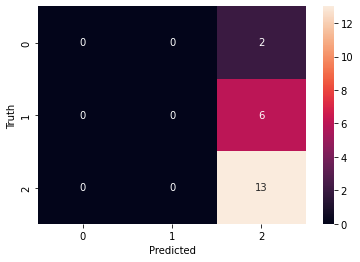

In [31]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
#  A confusion matrix is a table that is used to define the performance of a classification algorithm.
#  A confusion matrix visualizes and summarizes the performance of a classification algorithm
#  Compute confusion matrix to evaluate the accuracy of a classification.
        # Accuray is the ratio of number of correct predictions to the total number of input samples.

cm = confusion_matrix(y_test, clf.predict(X_test)) # y_true, y_pred
# test adatra a confusion matrix
# A confusion matrix is a tabular summary of the number of correct and incorrect predictions made by a classifier. 
# Tehát akkor a hibás predictelések számát mutatják a számok a CM-ben. 0: Complete, 1: Missing Cover, 2: Missing screw -szerintem

ax = sns.heatmap(cm, annot=True)
#sns.heatmap: Plot rectangular data as a color-encoded matrix - négyszögletes adat a rectangular data, ami most itt a confusion matrix
plt.xlabel('Predicted')
plt.ylabel('Truth')

print(classification_report(y_test, clf.predict(X_test))) # y_ture, y_pred
# The diagonal elements represent the number of points for which the predicted label is equal to the true label,
# while off-diagonal elements are those that are mislabeled by the classifier. 
# The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.


In [32]:
# saját, classification report átlátásához
for i in zip(y_test, clf.predict(X_test)):
    print(i[0], i[1])

Missing screw Missing screw
Complete Missing screw
Missing cover Missing screw
Missing screw Missing screw
Missing screw Missing screw
Missing screw Missing screw
Missing cover Missing screw
Missing screw Missing screw
Missing cover Missing screw
Missing screw Missing screw
Missing screw Missing screw
Missing screw Missing screw
Missing screw Missing screw
Missing screw Missing screw
Missing screw Missing screw
Complete Missing screw
Missing screw Missing screw
Missing cover Missing screw
Missing screw Missing screw
Missing cover Missing screw
Missing cover Missing screw


## Section 1.4: Image classification with artificial neural networks

In this section, we will train our first artificial neural network (ANN) for image classification.
First, we will have a look at normal ANNs. These consist of multiple dense (sűrű, tömör) layers which can analyze one-dimensional feature vectors. Thus, we need to reshape our 2.5-dimensional image data to 1D using the `flatten` option we integrated into our preprocessing function.

### a) Image classification using fully connected ANNs
Again, we need to load the data using the `flatten=True` flag to convert the 2.5D data to 1D.

In [33]:
features, labels = load_features_labels("./data/top", size=(128,128), color=True, flatten=True, identifiers=['MC', 'MS', 'C'])
features = np.asarray(features)
labels = np.asarray(labels)


print("Shape feature vector:", features.shape)
print("Shape label vector:", labels.shape)
print(labels)
print(labels[4])
# 70 db képet tölt be a 117-ből, mert a not screwed kategória hiányzik
# 128 x 128 x 3 = 49152, ez a pixelek száma * színkódok egy képnél, de 1 dimenzióra van flattenelve

Shape feature vector: (70, 49152)
Shape label vector: (70,)
['Complete' 'Missing cover' 'Missing cover' 'Missing cover'
 'Missing screw' 'Missing screw' 'Missing screw' 'Missing screw'
 'Missing screw' 'Missing screw' 'Missing cover' 'Missing cover'
 'Missing cover' 'Missing cover' 'Missing cover' 'Missing cover'
 'Missing cover' 'Missing cover' 'Missing cover' 'Missing cover'
 'Missing cover' 'Missing cover' 'Missing cover' 'Missing screw'
 'Missing screw' 'Missing screw' 'Missing screw' 'Missing screw'
 'Missing screw' 'Missing screw' 'Missing screw' 'Missing screw'
 'Missing screw' 'Missing screw' 'Missing screw' 'Missing screw'
 'Missing screw' 'Missing screw' 'Missing screw' 'Missing screw'
 'Complete' 'Missing cover' 'Missing screw' 'Missing screw'
 'Missing screw' 'Missing screw' 'Missing screw' 'Complete' 'Complete'
 'Complete' 'Complete' 'Missing cover' 'Missing cover' 'Missing cover'
 'Missing cover' 'Missing cover' 'Missing screw' 'Missing screw'
 'Missing screw' 'Missing sc

>**Task:** Fill in the following code so that 70% of the data is used for training, and the remaining 30% for testing. Also the datasets should be stratified by the label vector.

In [34]:
######################################
# Please complete the following line #
######################################
X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.7, stratify=labels, random_state=42)



# saját, értelmezéshez
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)
print("----")

# 49 a 70%-a a 70-nek, tehát jó
# 128 x 128 x 3 = 49152, ez a pixelek száma * színkódok egy képnél
print(X_train[0])
print(X_train)
print(X_train[0].shape)
print(X_train.shape[0])

print(y_train[0])
print(y_train[0].shape)

(49, 49152)
(21, 49152)
(49,)
(21,)
----
[27 54 82 ... 14 23 35]
[[ 27  54  82 ...  14  23  35]
 [ 30  64  93 ...  11  18  27]
 [ 24  48  77 ...  26  32  48]
 ...
 [ 17  30  44 ...   8  15  21]
 [ 33  69 104 ...  16  24  40]
 [ 18  40  61 ...  16  30  53]]
(49152,)
49
Missing cover
()


In [35]:
# saját, értelmezéshez, a onehot encoding értelmezéséhez
from sklearn.preprocessing import OneHotEncoder

enc1 = OneHotEncoder(sparse=False) 

y_train_onehot = enc1.fit_transform(y_train.reshape(-1, 1))
print(y_train_onehot.shape)

y_test_onehot = enc1.transform(y_test.reshape(-1, 1))
print(y_test_onehot.shape)

for i,j in enumerate(y_test_onehot):
    print(y_test[i], j ) 

print(y_test_onehot.shape)

(49, 3)
(21, 3)
Missing screw [0. 0. 1.]
Complete [1. 0. 0.]
Missing cover [0. 1. 0.]
Missing screw [0. 0. 1.]
Missing screw [0. 0. 1.]
Missing screw [0. 0. 1.]
Missing cover [0. 1. 0.]
Missing screw [0. 0. 1.]
Missing cover [0. 1. 0.]
Missing screw [0. 0. 1.]
Missing screw [0. 0. 1.]
Missing screw [0. 0. 1.]
Missing screw [0. 0. 1.]
Missing screw [0. 0. 1.]
Missing screw [0. 0. 1.]
Complete [1. 0. 0.]
Missing screw [0. 0. 1.]
Missing cover [0. 1. 0.]
Missing screw [0. 0. 1.]
Missing cover [0. 1. 0.]
Missing cover [0. 1. 0.]
(21, 3)


In [36]:
# saját, értelmezéshez
print(y_train)
print(y_train.shape)

print(y_train.reshape(-1, 1).shape)
print(y_train.reshape(-1, 1).ndim)

print(y_train.reshape(-1, 1))
print(y_train.reshape(-1, 1)[0].shape)
print(y_train.reshape(-1, 1).shape[0])
print(y_train.reshape(-1, 1).shape[1])

['Missing cover' 'Missing screw' 'Missing cover' 'Missing screw'
 'Missing screw' 'Complete' 'Complete' 'Missing screw' 'Missing screw'
 'Missing screw' 'Missing screw' 'Missing screw' 'Missing screw'
 'Missing cover' 'Missing screw' 'Missing screw' 'Missing screw'
 'Complete' 'Missing screw' 'Missing cover' 'Missing cover'
 'Missing cover' 'Missing screw' 'Missing cover' 'Missing screw'
 'Missing screw' 'Missing cover' 'Missing cover' 'Missing screw'
 'Complete' 'Missing cover' 'Missing screw' 'Missing screw'
 'Missing screw' 'Missing screw' 'Missing screw' 'Missing cover'
 'Missing cover' 'Missing screw' 'Missing screw' 'Missing screw'
 'Missing cover' 'Missing cover' 'Missing screw' 'Missing cover'
 'Missing screw' 'Missing cover' 'Missing screw' 'Missing screw']
(49,)
(49, 1)
2
[['Missing cover']
 ['Missing screw']
 ['Missing cover']
 ['Missing screw']
 ['Missing screw']
 ['Complete']
 ['Complete']
 ['Missing screw']
 ['Missing screw']
 ['Missing screw']
 ['Missing screw']
 ['Missi

The labels need to be *one hot encoded*. In one hot encoding, categorical values are transformed into a binary representatio, see here: .\img\OneHotEncoder.png

In [37]:
# The sklearn preprocessing library contains a variety of useful data preprocessing tools such as one hot encoding
from sklearn.preprocessing import OneHotEncoder

# Display the first label before encoding
print("Label of first sample before OneHot encoding:", y_train[0])


# Create the encoder object
enc = OneHotEncoder(sparse=False) # Generate Encoder
# creates a binary column for each category and returns a sparse matrix or dense array (depending on the sparse parameter)

# With the fit_transform function, the encoder is fitted to the existing labels and transforms the dataset into its binary representation
y_train = enc.fit_transform(y_train.reshape(-1, 1)) # mivel one hot encodinggal csak (n_samples, 1) formájú array-eket kódolunk át (n_features most 1, mert 1 labelja van minden sample-nek), és
                                                    # mivel layers can analyze one-dimensional feature vectors, ezért:
                                                    # a labeleket szövegként tartalmazó 1 db array helyett 
                                                    # mindegyik label-ből csinál egy 1 dimenziós array-t (ez lesz a one-dimensional feature vector), felette lévő cellában látszik, hogy hogyan
                                                    # a train-re fitteli

# Display the first label after encoding
print("Label of first sample after OneHot encoding:", y_train[0])

#az enc.fit_transform a training dataseten van, az enc.transform pedig a test dataseten
# Data preprocessing should always be fitted on the training dataset, but applied to both, the training and the testing dataset. Thus the fit_transform function is only applied to the training dataset, while the test dataset is transformed using the transform function and the fitted preprocessing module
y_test = enc.transform(y_test.reshape(-1, 1))

# a train-t és a test-t is transzformálni kell one-hot encodingos formára, de a fittelés csak a train-en van

Label of first sample before OneHot encoding: Missing cover
Label of first sample after OneHot encoding: [0. 1. 0.]


Now, let's define a simple ANN with an input layer, 3 hidden layer and one output layer.
In this lab we use the **keras** library to model the neural network. 

A simple ANN with multiple sequential layers can be created using the `Sequential()` model. Afterwards, various layers can be added to the model through the command `model.add(LAYER)` with *LAYER* defining the layer to be added. In the first layer, the shape of the input needs to be specified using the parameter `input_shape`. This is only necessary in the first, but not in consecutive layers.

Please have a look at the keras documentation regarding the [sequential model](https://keras.io/api/models/sequential/) and the [various layers](https://keras.io/api/layers/). For now, especially the core layers [Dense](https://keras.io/api/layers/core_layers/dense/) and [Activation](https://keras.io/api/layers/core_layers/activation/) are of interest. 

In [38]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Input, Dropout

print(X_train.shape)
print(X_train[0].shape)


fullyc_ANN_model = Sequential()

#ez az input layer
fullyc_ANN_model.add(Dense(32, input_shape = X_train[0].shape))  #  X_train[0].shape = (49152,)
fullyc_ANN_model.add(Activation("relu"))
# Dense: Just your regular densely-connected NN layer. Dense implements the operation: output = activation(dot(input, kernel) + bias)
# #In the first layer, the shape of the input needs to be specified using the parameter input_shape: 
# X_train[0].shape = (49152,) -> Now the model will take as input arrays of shape (None, 49152). 
# A None a sample_szám-ot jelenti, tehát a pl a (None, 49152) az (49, 49152)-t jelent, tehát a 49 képből 1 kép saját dimenziójának hossza 49152 (ami pixelek száma * színkódok = 128 x 128 x 3)
# 32: units paraméter, dimensionality of the output space - the model will output arrays of shape (None, 32). ((sample_szám, 32) formájú output array)
# Tehát ebben a Dense layerben ennyi (32) perceptron alakítja át a saját outputjává (y_i) ugyanazt az input képet (x1, x2, ..xn ből áll, mindegyik perceptron mindegyiket felhasználja)
# A perceptronok saját outputjai:  y_i outputja van: output_i = activation(dot(input x-ek, kernel_i) + bias_i), kernel_i az az adott perceptron saját weights-jei

# input_shape: ez egy képnél (feature vector) a pixelek száma * színkódok egy képnél: 128 x 128 x 3 = 49152, ilyenből van a train-nél 49, test-nél 21
# Activation: Applies an activation function to an output. relu: Rectified Linear Unit activation függvény (ami meghatározza hogy mekkora "action potential-t" kell küdeni az outputba), és ez a függvény negatív x-eknél 0-t ad vissza, pozitív x-eknél pedig y=x

#ez a 3 hidden layer, de azt nem tudom, hogy ez hogy 3 - úgy, hogy szerintem ez csak 1, és a CNN-nél már tényleg 3 hidden layer van, tehát szerintem lehet elírták
fullyc_ANN_model.add(Dense(16)) # 16: units paraméter - dimensionality of the output space - (sample_szám, 16) formájú output array
fullyc_ANN_model.add(Activation("relu"))

#output layer
fullyc_ANN_model.add(Dense(y_train[0].shape[0])) #y_train[0].shape[0] = 3, units paraméter - dimensionality of the output space (egy-egy sample saját dimenziója ilyen hosszú, azaz ennyi számot tartalmaz <- one hot encoding miatt)
fullyc_ANN_model.add(Activation("softmax"))
# a Dense layer outputolja a predictelt class labeleket 3 hosszúságú array-ek formájában (one hot encodingolt formában, mint az y_test_onehot),
# és ezeket a softmax valószínűséggé alakítja, tehát a 3 hosszúságú array-ek elemei mostmár valószínűségek,
# amik azt mutatják, hogy az adott class mennyire valószínű

print("------")
print(y_train.shape)
print(y_train[0].shape) #49-ből az első array shape-je
print(y_train[0].shape[0]) #ennek az első sample-nek (array-nek) az első dimenziójának (összesen 1 van) shape-je

print(fullyc_ANN_model.summary())

(49, 49152)
(49152,)
------
(49, 3)
(3,)
3
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1572896   
                                                                 
 activation (Activation)     (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 activation_1 (Activation)   (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 51        
                                                                 
 activation_2 (Activation)   (None, 3)                 0         
                                                                 
Total params:

Once the model is created, `model.summary()` displays the architecture of the model. You can see that the created model consists of three *dense* (sűrű) layers, each with an *activation* function. Also, the parameter for each layer are visible. Depending on the selected image size during preprocessing (itt most size=(128,128), ezért az egyes sample-k vectorjai 128x128x3-asok), the input vector might be rather large, thus the high number of parameters in the first dense layer. <br>
Első layer paraméter száma így jön ki: 49152 x 32, (=128x128x3 ,azaz egy input sample saját dimenziójának hossza) x (output sample-k saját dimenziójának hossza -unit paraméter mikor hozzáadjuk a Layer-t). A többi layer parameter számát nem tudom hogy jön ki. <br>
Paraméterek: minden layerben a perceptronoknak saját paramétereik vannak: weights and biases, ezekből vana az első layerben kb. 1 m 572 ezer, és lehet, és a 32 szerintem a perceptronok számát jelenti ebben a layerben

Next, the model needs to be compiled using a `loss` function and an `optimizer`. The loss function defines how the loss is computed during model training, while the optimizer defines how the weights need to be adjusted during backpropagation (szaporítás, terjesztés). You can find more information regarding the available losses [here](https://keras.io/api/losses/) and regarding the optimizers [here](https://keras.io/api/optimizers/).

In [39]:
fullyc_ANN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
# ekkor számolja ki az optimális paramétereket (w-k és b-k) a loss function minimalizálásával

# saját, értelmezéshez:
    # loss = 'categorical_crossentropy': már a labelek-ek one hot encodingolásával, és az output layer Dense(units=3)
    # és output layer Activation("softmax")-szal előkészítettük, most csak a class probability-ket (softmax outputja) alakítjuk
    # cross entropy értékké, ami azt mutatja, hogy mennyire távol van a predicted class a valóstól:
    # the loss function defines how the loss is computed during model training
    # de az output array-ek nem változnak ilyen cross entropy távolság értékké, hanem ezt csak a loss optimalizáláshoz 
    # (azaz a weights-ek jó irányú változtatásához) használja fel. Más szóval:
    # az optimization function = error function minimalizálása 'Adam' Gradient Descent-tel ->
    # "The optimization function 𝑓(𝜽) sums the loss functions categorical_crossentropy <- 𝐿(𝒚𝑖_kalap, 𝒚𝑖) of each individual data point (𝒙𝑖, 𝒚𝑖) in the training data"

    # optimizer = 'Adam' optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
    # szerintem ez a Gradient Descent egyik működési formája, "the optimizer defines how the weights need to be adjusted during backpropagation (hátrafelé szaporítás, terjesztés)"

    # metrics = ['Accuracy']: Accuray is the ratio of number of correct predictions to the total number of input samples.

Now, the model can be trained using the datasets defined before.

In [40]:
fullyc_ANN_model.fit(X_train, y_train, epochs = 20, batch_size = 8, validation_split=0.2, verbose = 1)

# saját, értelmezéshez:
    # epochs: An epoch is an iteration over the entire x and y data provided 

    # batch_size: Number of samples per gradient update. If unspecified, batch_size will default to 32.

    # validation_split: Float between 0 and 1. Fraction of the training data to be used as validation data.
    #  The model will set apart this fraction of the training data, will not train on it,
    #  and will evaluate the loss and any model metrics on this data at the end of each epoch.
    #  The validation data is selected from the last samples in the x and y data provided, before shuffling

    # verbose: Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch. 
            # loss az outputban most a Learning process pdf-ről az optimization functiont jelenti szerintem, tehát a loss-ok sum-ját:
                # "The optimization function 𝑓(𝜽) sums the loss functions (categorical_crossentropy <- 𝐿(𝒚𝑖_kalap, 𝒚𝑖)) of each
                # individual data point (𝒙𝑖, 𝒚𝑖) in the training data
                # egyébként ott említett optimization function = error function a Gradient Descent pdf-ről
            # és Gradient Descent-tel csökkenti, amit a batch-ok végén tesz meg, az outputba pedig csak az epoch-ok végén írja ki
            # és ezt kijelzi a training datasetre, meg a validation datasetre is:
            #   "will evaluate the loss and any model metrics on this data at the end of each epoch.""


Epoch 1/20
5/5 [==============================] - 1s 56ms/step - loss: 1522.3914 - accuracy: 0.5385 - val_loss: 1770.7546 - val_accuracy: 0.6000
Epoch 2/20
5/5 [==============================] - 0s 13ms/step - loss: 1536.3959 - accuracy: 0.5897 - val_loss: 512.0190 - val_accuracy: 0.6000
Epoch 3/20
5/5 [==============================] - 0s 13ms/step - loss: 671.9689 - accuracy: 0.5128 - val_loss: 154.1747 - val_accuracy: 0.5000
Epoch 4/20
5/5 [==============================] - 0s 12ms/step - loss: 261.3813 - accuracy: 0.5897 - val_loss: 43.3059 - val_accuracy: 0.6000
Epoch 5/20
5/5 [==============================] - 0s 12ms/step - loss: 36.5551 - accuracy: 0.7436 - val_loss: 30.3107 - val_accuracy: 0.6000
Epoch 6/20
5/5 [==============================] - 0s 19ms/step - loss: 22.0550 - accuracy: 0.5897 - val_loss: 60.7926 - val_accuracy: 0.4000
Epoch 7/20
5/5 [==============================] - 0s 12ms/step - loss: 10.7711 - accuracy: 0.7436 - val_loss: 36.2051 - val_accuracy: 0.4000
Epo

In [41]:
# saját, értelmezéshez

y_pred = fullyc_ANN_model.predict(X_test)
print(y_pred.shape)
print("------")
# ezek a predictelt, one-hot encodingolt formából Activation("softmax")-szal valószínűséggé alakított, 3 hosszúságú array-ek szerintem
# 7 hibát (eltérést) számoltam, és tényleg ennyi van a lentebbi confusion matrix-on
proba = zip(y_test, y_pred)
for i in proba:
    print(i[0], i[1])
print("-----")

res_proba = np.zeros_like(y_pred)
# mindegyik elemet 0-ra alakítja, de with the same shape and type as a given array
print(res_proba)
print("-----")

proba2 = [[1, 2, 3],
          [4, 5, 6]]
print(proba2[1][2])
#folytatás köv cellában

1/1 [==============================] - 0s 80ms/step
(21, 3)
------
[0. 0. 1.] [2.0369762e-01 7.9630232e-01 3.5217020e-08]
[1. 0. 0.] [4.6208132e-07 0.0000000e+00 9.9999952e-01]
[0. 1. 0.] [1.0418882e-15 0.0000000e+00 1.0000000e+00]
[0. 0. 1.] [5.3175835e-18 0.0000000e+00 1.0000000e+00]
[0. 0. 1.] [9.2093205e-01 4.3388205e-32 7.9067990e-02]
[0. 0. 1.] [1.1406785e-28 0.0000000e+00 1.0000000e+00]
[0. 1. 0.] [9.9956924e-01 3.8224952e-17 4.3071469e-04]
[0. 0. 1.] [1.2068166e-27 0.0000000e+00 1.0000000e+00]
[0. 1. 0.] [9.9999702e-01 1.7916793e-08 2.9611811e-06]
[0. 0. 1.] [9.7178066e-01 2.7744672e-22 2.8219312e-02]
[0. 0. 1.] [2.312766e-29 0.000000e+00 1.000000e+00]
[0. 0. 1.] [0.02272389 0.         0.97727615]
[0. 0. 1.] [4.3303172e-38 0.0000000e+00 1.0000000e+00]
[0. 0. 1.] [4.582584e-14 0.000000e+00 1.000000e+00]
[0. 0. 1.] [0. 0. 1.]
[1. 0. 0.] [6.0895747e-01 7.2578658e-29 3.9104250e-01]
[0. 0. 1.] [0. 1. 0.]
[0. 1. 0.] [1.5361266e-01 8.4172529e-38 8.4638739e-01]
[0. 0. 1.] [8.8811147e-0

In [42]:
# előző cella folytatása - saját, értelmezéshez
y_pred = fullyc_ANN_model.predict(X_test)
print(y_pred)
print("-----")
print(np.argmax(y_pred, axis=1))
# Returns the indices of the maximum values along an axis:
# a predictelt, one hot enc formájú array-ekből mindenegyik array-nél (képnél) visszaadja, hogy melyik indexű eleme az array-nak a legnagyobb,
# azaz melyik 1 = hányadik class-ra predictelte a képet
# axis = 1 azért kell, mert az y_pred 1. dimenziójában keressük a maximumot, azaz az egyes array-ekbenm, és nem az az array-ek között


print(len(np.argmax(y_pred, axis=1)))
# egyértelműen = 21, mert 21 test képünk van
print("---")

nulla_tol_20_ig_tartomany = range(len(np.argmax(y_pred, axis=1)))
print(nulla_tol_20_ig_tartomany)

for i in nulla_tol_20_ig_tartomany:
    print(i)


1/1 [==============================] - 0s 20ms/step
[[2.0369762e-01 7.9630232e-01 3.5217020e-08]
 [4.6208132e-07 0.0000000e+00 9.9999952e-01]
 [1.0418882e-15 0.0000000e+00 1.0000000e+00]
 [5.3175835e-18 0.0000000e+00 1.0000000e+00]
 [9.2093205e-01 4.3388205e-32 7.9067990e-02]
 [1.1406785e-28 0.0000000e+00 1.0000000e+00]
 [9.9956924e-01 3.8224952e-17 4.3071469e-04]
 [1.2068166e-27 0.0000000e+00 1.0000000e+00]
 [9.9999702e-01 1.7916793e-08 2.9611811e-06]
 [9.7178066e-01 2.7744672e-22 2.8219312e-02]
 [2.3127661e-29 0.0000000e+00 1.0000000e+00]
 [2.2723889e-02 0.0000000e+00 9.7727615e-01]
 [4.3303172e-38 0.0000000e+00 1.0000000e+00]
 [4.5825841e-14 0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]
 [6.0895747e-01 7.2578658e-29 3.9104250e-01]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00]
 [1.5361266e-01 8.4172529e-38 8.4638739e-01]
 [8.8811147e-01 8.5679516e-35 1.1188852e-01]
 [9.7090751e-01 2.1111043e-19 2.9092481e-02]
 [9.6297455e-01 6.1151555e-24 3.7025400e-02]]
--

You can use the following function to evaluate your model.

In [43]:
def evaluate_model(X_test, y_test, model):
    import seaborn as sns
    from sklearn.metrics import confusion_matrix, classification_report
    #azok a változók, amiket a függvény inputjaként nem említ itt meg, azok a függvény belső változói, nem megváltoztathatóak fv hívásakor (pl. y_pred)

    y_pred = model.predict(X_test)    
    # test adatokon (képeken) predicteljük a labeleket (classok) a modellel (az épp adott modelt a model = Sequential() -lal hoztuk létre)

    y_pred_reset_0ra = np.zeros_like(y_pred)
    # y_pred alakú (azaz (21,3), csak 0-kat tartalmazú array-eket ad vissza

    for i in range(len(np.argmax(y_pred, axis=1))):
    # range(len(np.argmax(y_pred, axis=1))) = range (0, 21) - 0-tól 20-ig terjedő tartomány

        y_pred_reset_1_re = y_pred_reset_0ra
        y_pred_reset_1_re[i, np.argmax(y_pred, axis=1)[i]] = 1
        # tehát a 3 hosszűságú, csak 0-kat tartalmazó array-ekből kiválasztjuk az i-ediket, majd ezen belül
        # a megfelelő index segítségével kiválasztjuk azt az elemet, ami az y_pred i-edik array-en belül a legnagyobb - legmagasabb valószínűségű class (azaz pl 1.0000000e+00 valószínűség),
        # és ezt az elemet egyenlővé tesszük 1-gyel: eddig is ez volt a legnagyobb elem az y_pred-en belül, de pl ilyen formában hogy 1.0000000e+00 - mert a megfelelő class valószínűségét mutatja a softmax trans által,
        # ehelyett 1-t adunk neki (ezt értem az "értékek reset normalra" alatt)
        # a többi elem 0 marad közben - tehát a valószínűségek közül, a legvalószínűbb értékét 1-re állítjuk, a többit pedig 0-ra

    y_pred_0v1re_resettelve = y_pred_reset_1_re

    cm = confusion_matrix(enc.inverse_transform(y_test), enc.inverse_transform(y_pred_0v1re_resettelve)) # y_true, y_pred
    # y_true paraméter: enc.inverse_transform(y_test) - tehát a one hot enc formára alakított y_test array-ek szöveges labelre (classok) visszatranszformálása
    # y_pred paraméter: az y_pred one hot encoding formájú értékek nem egész 0-k ról vagy nem egész 1-ekről 0-ra vagy 1-re alakított, 3 hosszúságú arrayek
    #                   visszaalakítása szöveges labellé, tehát a predictelt szöveges labeleket (predictelt class-okat) adjuk meg

    ax = sns.heatmap(cm, annot=True)
    # data = cm: rectangular dataset, itt most a confusion matrix
    plt.xlabel('Predicted')
    plt.ylabel('Truth')

    print(classification_report(enc.inverse_transform(y_test), enc.inverse_transform(y_pred_0v1re_resettelve), zero_division=0))
    # zero_division (osztás) : "warn", 0 or 1    default="warn"
    # Sets the value to return when there is a zero division. If set to "warn", this acts as 0, but warnings are also raised.



    # saját, értelmezéshez, fv kiegészítése:
    for i,j in enumerate(y_pred):
        print(y_pred_0v1re_resettelve[i], j)
    print("-----")

    for i, j in enumerate(enc.inverse_transform(y_test)):
        print(i,j)
    print("-----")

    for i, j in enumerate(enc.inverse_transform(y_pred_0v1re_resettelve)):
         print(i,j)
    print("-----")
    
    print(enc.inverse_transform(y_test).shape)
    print(enc.inverse_transform(y_pred_0v1re_resettelve).shape)

1/1 [==============================] - 0s 63ms/step
               precision    recall  f1-score   support

     Complete       0.12      0.50      0.20         2
Missing cover       0.00      0.00      0.00         6
Missing screw       0.73      0.62      0.67        13

     accuracy                           0.43        21
    macro avg       0.28      0.37      0.29        21
 weighted avg       0.46      0.43      0.43        21

[0. 1. 0.] [2.0369762e-01 7.9630232e-01 3.5217020e-08]
[0. 0. 1.] [4.6208132e-07 0.0000000e+00 9.9999952e-01]
[0. 0. 1.] [1.0418882e-15 0.0000000e+00 1.0000000e+00]
[0. 0. 1.] [5.3175835e-18 0.0000000e+00 1.0000000e+00]
[1. 0. 0.] [9.2093205e-01 4.3388205e-32 7.9067990e-02]
[0. 0. 1.] [1.1406785e-28 0.0000000e+00 1.0000000e+00]
[1. 0. 0.] [9.9956924e-01 3.8224952e-17 4.3071469e-04]
[0. 0. 1.] [1.2068166e-27 0.0000000e+00 1.0000000e+00]
[1. 0. 0.] [9.9999702e-01 1.7916793e-08 2.9611811e-06]
[1. 0. 0.] [9.7178066e-01 2.7744672e-22 2.8219312e-02]
[0. 0. 1.]

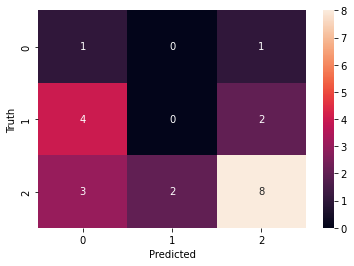

In [44]:
evaluate_model(X_test, y_test, fullyc_ANN_model)
#az evaluate_model fv kiegészítése (értelmezéshez) miatt hosszabb az output, text editorban érdemes nézni, az CM értelmezéséhez készítettem belőle átlátható output-t Excel-ben (.\Saját képek és Excel\fully connected ANNS confusion matrix kiértékelés.xlsx)

>**Question:** What behavior did you observe while training the model? How can the results be explained?

**SOLUTION**:

> Using the ANN with the given parameters, no training can be observed. This can be seen both in the low prediction accuracy on the validation data (tényleg alacsonyan maradt: val_accuracy: 0.3000), as well as the confusion matrix, showing only one class being predicted. (kissé érthetetlen megfogalmazás)

> A potential explanation might be the relation of high amounts of free parameters (> 6 million - csak 1,5 millió van igazából, nem tudom honnan jött a 6 m) with the low amount of training data (~80 images - 59 training/21 teszt kép arányra bontottuk a 70 képet). This low volume of training data might just not be enough to fit that many parameters. Also, the network architecture might not be optimized regarding the respective problems.

### b) Image classification using CNNs

In this section, we are going to explore the usage of CNNs for the given task.

First, the data is loaded from file. As CNNs are capable and even excel on analyzing the multiple dimensional aspects of images, the images do not need to be reshaped in a one-dimensional vector. Thus, we have to set the flag `flatten` to `False`. You can see, that the shape of the loaded images is now a four-dimensional array with `(number of samples, width image, height image, color channels image)`.

In [38]:
features, labels = load_features_labels("./data/top", size=(512,512), color=True, flatten=False, identifiers=['MC', 'MS', 'C'])

features = np.array(features) # Datatype conversion of feature vector from list to array
labels = np.array(labels) # Datatype conversion of label vector from list to array
# feature és label *vector*-nak hívja ezeket, amik az összes featuret-labelt tartalmazzák
# itt már nem np.asarray-t használ, hanem csak sima np.array-t

print("Shape feature vector:", features.shape)
print("Shape label vector:", labels.shape)
# numbers of samples, width of an image, height of an image, color channels of an image
print(labels)
print(features)

Shape feature vector: (70, 512, 512, 3)
Shape label vector: (70,)
['Complete' 'Missing cover' 'Missing cover' 'Missing cover'
 'Missing screw' 'Missing screw' 'Missing screw' 'Missing screw'
 'Missing screw' 'Missing screw' 'Missing cover' 'Missing cover'
 'Missing cover' 'Missing cover' 'Missing cover' 'Missing cover'
 'Missing cover' 'Missing cover' 'Missing cover' 'Missing cover'
 'Missing cover' 'Missing cover' 'Missing cover' 'Missing screw'
 'Missing screw' 'Missing screw' 'Missing screw' 'Missing screw'
 'Missing screw' 'Missing screw' 'Missing screw' 'Missing screw'
 'Missing screw' 'Missing screw' 'Missing screw' 'Missing screw'
 'Missing screw' 'Missing screw' 'Missing screw' 'Missing screw'
 'Complete' 'Missing cover' 'Missing screw' 'Missing screw'
 'Missing screw' 'Missing screw' 'Missing screw' 'Complete' 'Complete'
 'Complete' 'Complete' 'Missing cover' 'Missing cover' 'Missing cover'
 'Missing cover' 'Missing cover' 'Missing screw' 'Missing screw'
 'Missing screw' 'Miss

>**Task:** Fill in the following code so that 70% of the data is used for training, and the remaining 30% for testing. Also, the datasets should be stratified by the label vector. Furthermore, add OneHot Encoding for the labels as seen before.

In [51]:
#######################################
# Please complete the following lines #
#######################################

def split_data(features, labels):
    #Your code goes here
    return train_test_split(features, labels, train_size=0.7, stratify=labels, random_state=42) 


def encode_labels(y_train, y_test):
    enc = OneHotEncoder(sparse=False) # Generate Encoder
    # creates a binary column for each category and returns a sparse matrix or dense array (depending on the sparse parameter)
    
    y_train = enc.fit_transform(y_train.reshape(-1, 1)) # Fit and transform training label data

    #az enc.fit_transform a training dataseten van, az enc.transform pedig a test dataseten
    # Data preprocessing should always be fitted on the training dataset, but applied to both, the training and the testing dataset. 
    # Thus the fit_transform function is only applied to the training dataset, while the test dataset is transformed using the transform function and the fitted preprocessing module
    
    y_test = enc.transform(y_test.reshape(-1, 1))  # Transform testing datal abels

    return y_train, y_test


# splitting
X_train, X_test, y_train, y_test = split_data(features, labels)



# doing the encoding for the train and test labels
print("Label of first sample before OneHot encoding:", y_train[0])

y_train, y_test = encode_labels(y_train, y_test)

print("Label of first sample after OneHot encoding:", y_train[0])

#saját, értelmezéshez
print(y_train.shape)
print(y_train.shape[0]) # 0. dimenzió shapeje
print("y_train[0].shape:", y_train[0].shape) # y_train 0. elemének shape-je
print("-------")
print(y_train)

################
# Quality gate #
################

quality_gate_141(y_train, y_test)

Label of first sample before OneHot encoding: Missing cover
Label of first sample after OneHot encoding: [0. 1. 0.]
(49, 3)
49
y_train[0].shape: (3,)
-------
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


'Quality gate passed :)'

In [117]:
# saját, értelmezéshez
a = np.array([[1, 2, 3],
               [4, 5,6 ],
               [7, 8, 9]])
print(a.shape)
print(a.ndim)
print(a[0].shape)
print(a[0].ndim)

(3, 3)
2
(3,)
1


In [57]:
# saját, értelmezéshez
print(X_train.shape)
print(X_train[0].shape)
print("------")

print(y_train.shape)
print(y_train[0].shape)
print(y_train[0].shape[0])

(49, 512, 512, 3)
(512, 512, 3)
------
(49, 3)
(3,)
3


In [63]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D, GlobalMaxPooling2D

CNN_model = Sequential()

CNN_model.add(Conv2D(8, 5,  input_shape = X_train[0].shape, activation = "relu", padding="same"))
CNN_model.add(MaxPooling2D())
# This layer creates a convolution kernel that is convolved (összecsavar, összesodor) with the layer input to produce a tensor of outputs.
#  
# filters = 8 | filters: Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution)
            # tehát a kernelek, azaz convolution filter mátrixok száma, és az output array-nek ilyen shape lesz: (sample_szám, 8). Tehát ennyi convolutional operation (input * (weight mátrix=convolution window shiftelve) lesz ugyanazon az input képen
# kernel_size = 5 | kernel_size: An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window. Can be a single integer to specify the same value for all spatial dimensions.
            # tehát az egyes kernelek convolutional filter mátrixának a mérete
# input_shape = X_train[0].shape | When using a layer as the first layer in a model, provide the keyword argument input_shape
            # (tuple of integers, does not include the sample axis), e.g. input_shape=(128, 128, 3) for 128x128 RGB pictures in data_format="channels_last".
# activation = "relu" | Activation: Applies an activation function to an output. relu: Rectified Linear Unit activation függvény (ami meghatározza hogy mekkora "action potential-t" kell küdeni az outputba), és ez a függvény negatív x-eknél 0-t ad vissza, pozitív x-eknél pedig y=x
            # tehát ebben a layerben mindegyik perceptronnak (nem tudom hány van) ugyanaz az activation function-je
# padding="same" | padding: helykitöltés, "same" results in padding with zeros evenly to the left/right or up/down of the input. Szerintem a pooling stride-jával kapcsolatban

# Maxpooling2D(): Downsamples the input (a filterek outputja az input) along its spatial dimensions (height and width) 
# by taking the maximum value over an input window (of size defined by pool_size)
# for each channel of the input. The window is shifted by strides along each dimension.

CNN_model.add(Conv2D(16, 3, activation = 'relu', padding="same"))
CNN_model.add(MaxPooling2D())
# 16 db convolutional filter mátrix, (sample_szám, 16) formájú output array, 3x3-as méretűek ezek a mátrixok, 
# az activation function negatív bemenő argumentumnál 0 action potentialt küld az outputba, pozitívnál annyit mint az argumentum értéke, az inputot, ami (512, 512, 3) array (és ez 49x, mert 49 kép van), valahogy helykitölti, szerintem azért, hogy négyzet alakú legyen-filter mátrixnak, hogy lehessen könnyen szorozni

CNN_model.add(Conv2D(32, 3, activation = 'relu', padding="same"))
CNN_model.add(GlobalMaxPooling2D())
# 32 convolutional filter mátrix, (sample_szám, 32) formájú output array, 3x3-as méretűek ezek a mátrixok
# GlobalMaxPooling2D(): Global max pooling operation for spatial data. -szerintem olyasmi, hogy nem csak egy window (=subet) 
# of inputon Pool-ol (összegez), és nincsenek window shiftek, hanem az egész inputon (előző layer outputja) Pool-ol, mert ez az utolsó Convolutional-Pooling layer
# (None, 128, 128, 32) output shape-ből csinált (None, 32) formájút

CNN_model.add(Dense(32, activation = 'relu'))
# Dense: Just your regular densely-connected NN layer. Dense implements the operation: output = activation(dot(input, kernel) + bias)
# 32: units paraméter, dimensionality of the output space - the model will output arrays of shape (None, 32). ((sample_szám, 32) formájú output array)
# Tehát ebben a Dense layerben ennyi (32) perceptron alakítja át a saját outputjává (y_i) ugyanazt az input képet (x1, x2, ..xn ből áll, mindegyik perceptron mindegyiket felhasználja)
# A perceptronok saját outputjai:  y_i outputja van: output_i = activation(dot(input x-ek, kernel_i) + bias_i), kernel_i az az adott perceptron saját weights-jei

CNN_model.add(Dense(y_train[0].shape[0], activation = 'softmax'))
# ANN-nél utolsó rétegként egy Activation réteget adott hozzá, és azt adta meg "softmax"-ként, most az utolsó 2 réteg Dense, és az utolsó Dense activation-je a softmax
# tehát most az utolsó (output) Dense layer outputolja a predictelt class labeleket (sample_szám, 3) formájú arrayként (one hot encodingolt formában), viszont
# ezeket a softmax activation valószínűséggé alakítja, tehát az egy-egy 3 hosszúságú array elemei mostmár valószínűségek,
# amik azt mutatják, hogy az adott class-ra predictelés mennyire valószínű

print(CNN_model.summary())
# ANN-nél, az elsp Dense layernél az Output Shape nem az input_shape-ként megadott (49152,) shape-t vette fel,
# hanem a Dense layer units paramétereként megadott 32-t (Dense(32, ...), így: Output shape oszlop: (None, 32)

# Output shape 4. dimenzióját az input_shape-hez képest (ott (...., 3) volt) 3-ról 8-ra írta át, az első layer filters paramétere miatt. "Filters : Integer, the dimensionality of the output space"
# Ez azt jelenti, hogy az adott layer outputja ennyi output mátrixból áll (mert ennyi convolutional operation volt-azaz input kép * filter mátix), 
# ezek az output mátrixok mérete a filter mátrix méretével egyenlő (pl 3x3), és ezeket az output mátrixokat fűzi össze hogy megkapja a layer teljes outputját

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 512, 512, 8)       608       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 256, 256, 8)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 256, 256, 16)      1168      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 global_max_pooling2d_1 (Glo  (None, 32)              

In [68]:
from tensorflow.keras.optimizers import Adam

optimizer=Adam(learning_rate=0.001)


CNN_model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'], weighted_metrics=[])
# ekkor számolja ki az optimális paramétereket (w-k és b-k) a loss function minimalizálásával


# loss = 'categorical_crossentropy': már a labelek-ek one hot encodingolásával, és az output layer Dense(units=3)
# és output layer Activation("softmax")-szal előkészítettük, most csak a class probability-ket (softmax outputja) alakítjuk
# cross entropy értékké, ami azt mutatja, hogy mennyire távol van a predicted class a valóstól:
# the loss function defines how the loss is computed during model training
# de az output array-ek nem változnak ilyen cross entropy távolság értékké, hanem ezt csak a loss optimalizáláshoz 
# (azaz a weights-ek jó irányú változtatásához) használja fel. Más szóval:
# az optimization function = error function minimalizálása 'Adam' Gradient Descent-tel ->
# "The optimization function 𝑓(𝜽) sums the loss functions categorical_crossentropy <- 𝐿(𝒚𝑖_kalap, 𝒚𝑖) of each individual data point (𝒙𝑖, 𝒚𝑖) in the training data"

# optimizer = 'Adam' optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
# ez a Gradient Descent egyik működési formája, "the optimizer defines how the weights need to be adjusted during backpropagation (hátrafelé szaporítás, terjesztés)"
# learning rate-t jól kell megválaztani, hogy ne legyen túl nagy (mert akkor egyik oldalról a másikra ugrál az error function update-je, és a minimum körül ugrál a végén, nem elérve azt)
# túl kicsi se lehet, mert akkor nagyon sokáig tart, míg a minimumba ér, vagy egyáltalán nem is ér oda

# metrics = ['Accuracy']: Accuray is the ratio of number of correct predictions to the total number of input samples.

# weighted_metrics: én tettem hozzá, mert mivel az eggyel lentebbi cellában adtunk meg sample_weight-t, ezért ezekre a súlyozott class labelekre vonatkozó metrikára is meg kell adni,
#  hogy milyen metrika módszert haszáljon (itt most semmilyet). Különben hibaüzenet fitteléskor.
#       List of metrics to be evaluated and weighted by sample_weight or class_weight during training and testing.


In [69]:
CNN_model.fit(X_train, y_train, epochs = 75, batch_size = 32, validation_split=0.1, 
          verbose = 1, sample_weight=compute_sample_weight('balanced', y_train))

# saját, értelmezéshez:
    # eredetileg np.array(X_train), np.array(y_train), de ezek már egyébként is array-ek:
    # Az X_train, X_test, y_train, y_test = split_data(features, labels) általunk írt fv eredetileg listákat adna vissza, és nem array-eket, 
    # de mivel a features-t, labels-t a fv hívása előtt már array-jé alakítottuk, így itt már felesleges megint ezzé alakítani, töröltem

    # epochs: An epoch is an iteration over the entire x and y data provided 

    # batch_size: Number of samples per gradient update. If unspecified, batch_size will default to 32.

    # validation_split: Float between 0 and 1. Fraction of the training data to be used as validation data.
    #  The model will set apart this fraction of the training data, will not train on it,
    #  and will evaluate the loss and any model metrics on this data at the end of each epoch.
    #  The validation data is selected from the last samples in the x and y data provided, before shuffling

    # verbose: Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch. 
            # loss az outputban most a Learning process pdf-ről az optimization functiont jelenti szerintem, tehát a loss-ok sum-ját:
                # "The optimization function 𝑓(𝜽) sums the loss functions (categorical_crossentropy <- 𝐿(𝒚𝑖_kalap, 𝒚𝑖)) of each
                # individual data point (𝒙𝑖, 𝒚𝑖) in the training data
                # egyébként ott említett optimization function = error function a Gradient Descent pdf-ről
            # és Gradient Descent-tel csökkenti, amit a batch-ok végén tesz meg, az outputba pedig csak az epoch-ok végén írja ki
            # és ezt kijelzi a training datasetre, meg a validation datasetre is:
            #   "will evaluate the loss and any model metrics on this data at the end of each epoch.""

    #  sample_weight = compute_sample_weight('balanced', y_train): Weights associated with classes in the form {class_label: weight}. 
    #       If not given, all classes are supposed to have weight one. 
    #       The "balanced" mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data

Epoch 1/75
2/2 [==============================] - 5s 2s/step - loss: 0.0205 - accuracy: 0.9773 - val_loss: 2.6562 - val_accuracy: 0.6000
Epoch 2/75
2/2 [==============================] - 4s 1s/step - loss: 0.5457 - accuracy: 0.8864 - val_loss: 0.7236 - val_accuracy: 0.4000
Epoch 3/75
2/2 [==============================] - 5s 1s/step - loss: 0.3513 - accuracy: 0.5682 - val_loss: 0.3680 - val_accuracy: 0.8000
Epoch 4/75
2/2 [==============================] - 5s 2s/step - loss: 0.0605 - accuracy: 0.9318 - val_loss: 0.7644 - val_accuracy: 0.8000
Epoch 5/75
2/2 [==============================] - 5s 2s/step - loss: 0.0892 - accuracy: 0.9318 - val_loss: 1.0737 - val_accuracy: 0.6000
Epoch 6/75
2/2 [==============================] - 5s 2s/step - loss: 0.2665 - accuracy: 0.9318 - val_loss: 1.1346 - val_accuracy: 0.6000
Epoch 7/75
2/2 [==============================] - 5s 1s/step - loss: 0.0920 - accuracy: 0.9773 - val_loss: 1.0001 - val_accuracy: 0.0000e+00
Epoch 8/75
2/2 [=====================

Evaluate the trained CNN

1/1 [==============================] - 1s 619ms/step
               precision    recall  f1-score   support

     Complete       0.00      0.00      0.00         2
Missing cover       0.67      0.67      0.67         6
Missing screw       0.85      0.85      0.85        13

     accuracy                           0.71        21
    macro avg       0.50      0.50      0.50        21
 weighted avg       0.71      0.71      0.71        21

[0.5739958  0.20657426 0.2194299 ] [1. 0. 0.]
[0.01639538 0.7387883  0.24481633] [0. 1. 0.]
[0.4914622  0.41110638 0.09743149] [1. 0. 0.]
[1.14179114e-04 3.49715957e-03 9.96388674e-01] [0. 0. 1.]
[0.02080513 0.01049822 0.96869665] [0. 0. 1.]
[4.5019246e-06 3.9886616e-02 9.6010894e-01] [0. 0. 1.]
[5.5616413e-04 9.9944335e-01 4.2782906e-07] [0. 1. 0.]
[1.2101525e-04 2.5261511e-04 9.9962640e-01] [0. 0. 1.]
[3.86755681e-04 9.99498606e-01 1.14662595e-04] [0. 1. 0.]
[0.0010499  0.00620241 0.9927477 ] [0. 0. 1.]
[1.4623128e-05 8.2113994e-03 9.9177402e-01] [0. 

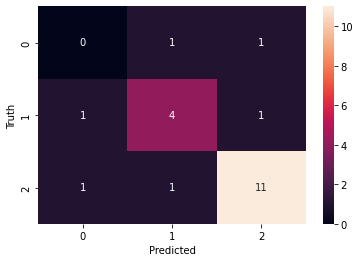

In [70]:
evaluate_model(X_test, y_test, CNN_model)
#TEXT EDITORBAN NÉZNI A HOSSZA MIATT, az evaluate_model fv kiegészítése (értelmezéshez) miatt hosszabb az output 

>**Question:**
>- How does the CNN perform compared to the ANN?
>- What could be reasons for the different performances?

>**Answer:** saját: <br>
Az SVC (Support Vector Classification - SVM Classificationre haználva (Regressionre lehetne még használni)) 8x hibázott, a fully connected ANN 7x (a legutolsó fitteléskor 12x), a CNN pedig 6x<br>
A neruális hálók sokkal komplexebbek, mint az SVC. ANN vs. CNN: CNN reálisabban modellezi a valós, emberi neurális hálók működését,<br>
a Convolutional operation-k (Convolutional Layerek) által az inputot kisebb alhalmazokként (subset) dolgozza fel, és mindig csak egy kicsit mozgatja a window-t,<br>
tehát átfedéssel dolgozza fel a subseteket, így sokkal komplexebb-pontosabb a CNN, <br>
Convolutional layer: this layer creates a convolution kernel that is convolved (összecsavar, összesodor) with the layer input to produce a tensor of outputs. <br>
 emellett sokkal nagyobb epoch és batch_size-t adtunk meg, valamint az SVC és CNN esetében <br>számíttattunk (balanced) a class-oknak súlyokat (sample_weight), az ANN-nél nem <br> emellett CNN-nél a képeket a saját dimenziójuk szerint (pl 512 x 512 x 3) tudjuk tárolni ugyanilyen formájú array-ekben, tehát adat betöltéskor nem kell 1 dimenziósra laposítanuk (Flatten=False) a features és labels array-eket, melyekből splitteléssel lesz az X_train, X_test, y_train, y_test 

>**Task:**
>With the above starter code, a first improvement in accuracy compared to the SVM and the ANN-using only Dense layers should be visible. However, the network could be further improved by adjusting the hyperparameters (a hyperparaméterek azok a paraméterek, amiket mi adunk meg (external), és amiket magának számol ki (internal), azok a paraméterek). Below you can find the full snippet from data preprocessing to model training. Play around with the parameters and see whether you can find a model that shows an even better performance!
>
>Some ideas are:
>- Explore different sized images (smaller/larger)
>- How do black and white images compare to the rgb ones?
<br>**Adapt the architecture of the neural network:**
> - Change the amount of Conv2D layers
> - Change the number of filters in each layer - első hyperparaméter ("units")
> - Explore other activation functions
>- Change the learning rate of the optimizer or look at different optimizers all together
>- Train the model for more epochs

</div>

In [ ]:
np.random.seed(28)
# értelmezés: "If you set the np.random.seed(a_fixed_number) every time you call the numpy's other random function, the result will be the same" -bár nem tudom, hogy hol használ numpy's random function-t

####################################################
# Please modify the following lines       
# ! For comparability, please don't change the ratios for train/test and train/validation! #  -train/test ratio-t nem is lehet itt változtatni, mert a split_data fv-be van beleírva az arányuk, a train/validation ratio-t lehetne változtatni a model.fit-nél a validation_split hyperparaméterrel
####################################################

# Data preprocessing
features, labels = load_features_labels("./data/top", size=(512,512), color=True, flatten=False, identifiers=['MC', 'MS', 'C']) # képek felbontása 512x512-re állítva
features = np.array(features) # Datatype conversion of feature vector from list to array
labels = np.array(labels) # Datatype conversion of label vector from list to array

X_train, X_test, y_train, y_test = split_data(features, labels) # Split features and labels into training and testing datasets
y_train, y_test = encode_labels(y_train, y_test) # Encode labels (One-hot encodingos formára alakítja az array-eket, (49,) és (21,) shape-ből lesz (49, 3) és (21, 3) formájú array-ek
# Data preprocessing vége

# saját, értelmezéshez + importok
print(type(X_train))
print(X_train[0].shape)
from keras.models import Sequential  #ezeket a libraryket azért importálom, mert ahol előzőleg importálva voltak, ott ezzel együtt a modellt is felépítettük, és nem célszerű újra felépíteni azokat a modelleket (pl eredményük tárolása miatt)
from keras.layers import Dense, Activation 
from keras.layers import Conv2D, Dense, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Model definition
model = Sequential()
model.add(Conv2D(16, 4,  input_shape = X_train[0].shape, activation = 'tanh', padding="same")) # filterek (=convolutional/filter mátrixok = kernelek) száma ezen a layeren belül 16-ra növelve, és a 16 filter mátrix 4x4-re növelve, X_train[0].shape = (512, 512, 3)
model.add(MaxPooling2D())                                                                      # Hyperbolic tangent activation function-nel is próbálkoztam, meg Sigmoid-dal is a ReLu mellett

model.add(Conv2D(32, 4, activation = 'tanh', padding="same")) # + 1 db layer 32 filterrel, 4x4-es filter mátrixokkal (6 db)filterek (=convolutional/filter mátrixok = kernelek) száma ezen a layeren belül 12-re növelve, és a 12 filter mátrix 5x5-ra növelve
model.add(MaxPooling2D())

model.add(Conv2D(64, 4, activation = 'tanh', padding="same")) # filterek (=convolutional/filter mátrixok = kernelek) száma ezen a layeren belül 64-re állítva, és a 64 filter mátrix 4x4-re állítva
model.add(GlobalMaxPooling2D())

model.add(Dense(64, activation = 'tanh'))

model.add(Dense(y_train[0].shape[0], activation = 'softmax')) # y_train[0].shape[0] = 3 a one hot enc forma miatt

# Model compilation
optimizer = Adam(learning_rate=0.002) # learning rate 0.002 -re állítva: nagyobb lépés a kevesebb (75-höz képest) epoch miatt, illetve hogy gyorsabban közelítsen a 0 a loss fv minimumához (de nem túl nagy, hogy ne ugráljon a fv egyik oldaláról a másikra)
model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'], weighted_metrics=[]) # weighted_metrics üresen hozzáírtam, hogy ne legyen hibaüzenet

# Model training
model.fit(X_train, y_train, epochs = 60, batch_size = 40, validation_split=0.1, # epochs 60-ra, batch_size 40-re állítva
          verbose = 1, sample_weight=compute_sample_weight('balanced', y_train))

# Model evaluation
evaluate_model(X_test, y_test, model) 

Próbálkoztam sokféle hyperparaméterrel (Activation functoinnel, batch és epoch méretekkel,  learning_rate-tel, képeket tároló array-k méretével, stb), de a legjobb accuracy, amit el tudtam érni, is csak 0.95 volt, aminél az előző CNN modell jobb volt (1-es acc) <br>
A különböző hyperparaméterű modelleket Google Colab-ban futtattam, mert ott gyorsabbak a számítások (erősebb cloud által biztosított CPU és GPU), illetve nem terheli túl a saját hardware-t (túlmelegedés)

## Section 1.5: Data augmentation

Data augmentation (növelés, gyarapítás) is a technique for artificially increasing the dataset without the need for additional data acquisition. The reason for this is, that most machine learning models perform better the higher the available data volume is. 

Data augmentation uses the principle of slight modifications to the original data to create new data, while using the labels of the existing image. (Tehát a módosított kép labelje ugyanaz, mint az eredeti adaté) As those modifications are rather small, the image as a whole is not changed by a lot and the to be identified object, or in our case image class, can still be recognized. However, the training process can be increased significantly. One can think of many variations of these slight modifications of an image. Typical examples include:
- Random flipping of the image horizontally or vertically
- Random rotations
- Random shifts
- Blurring the image
- Adding artificially created noise
- Cropping
- Changes in contrast
- Elastic deformations

Below you can see some examples of the different augmentation strategies applied to our dataset

#### Implementation in keras
**Keras** includes its own procedure for image augmentation using the `ImageDataGenerator` generator. This generator offers a variety of data augmentation strategies, that are directly applied to the raw data during model training. Thus, the augmented data does not need to be stored to the disk. (Tehát a módosításokat a training alatt végzi el, így az új, modosított képeket nem kell külön létrehozni és tárolni)

For this exercise, we are going to use the ImageDataGenerator from keras. Please have a look at the documentation to get familiar: https://keras.io/api/preprocessing/image/#imagedatagenerator-classData augmentation is a technique for artificially increasing the dataset without the need for additional data acquisition. The reason for this is, that most machine learning models perform better the higher the available data volume is. 

In [126]:
# Data preprocessing
features, labels = load_features_labels("./data/top", size=(512,512), color=True, flatten=False, identifiers=['MC', 'MS', 'C'])

features = np.array(features) # Datatype conversion of feature vector from list to array
labels = np.array(labels) # Datatype conversion of label vector from list to array

X_train, X_test, y_train, y_test = split_data(features, labels) # Split features and labels into training and testing datasets

y_train, y_test = encode_labels(y_train, y_test) # Encode labels

print(X_train.shape)
print(y_train.shape)

(49, 512, 512, 3)
(49, 3)


In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [108]:
### Create and show data augmentation
datagen = ImageDataGenerator(  # dokumentációból: Generate batches of tensor image data with real-time data augmentation. The data will be looped over (in batches).
    featurewise_center=False,   # Boolean. Set input mean to 0 over the dataset, feature-wise.
    featurewise_std_normalization=False, # Boolean. Divide inputs by std of the dataset, feature-wise.
    rotation_range=10, # Int. Degree range for random rotations.
    width_shift_range=0.2, # float: fraction of total width, if < 1, or pixels if >= 1.
    height_shift_range=0.2, # float: fraction of total height, if < 1, or pixels if >= 1.
    horizontal_flip=True, # Boolean. Randomly flip inputs horizontally.
    vertical_flip=True) # Boolean. Randomly flip inputs vertically.

In [109]:
random_index = random.randint(0, len(features)) # Randomly select one image (pontosabban: itt még nem a képet választja ki random, csak annak az indexét)
# dokumentáció: randint: Return random integer in range [a, b], including both end points.
# len(features) = 70, mert 70 kép van
print(features.shape)
print(features[12].shape)
print(features[[12]].shape)

datagen.fit(features[[random_index]]) # Fit the image generator with the randomly selected image (random kiválasztott képen "tanítjuk")

# azért kell [[]], mert "The fit method of ImageDataGenerator expects an input with four dimensions (n_samples, height, width, n_channels)"",
# tehát lehetne több képet is megadni, de most 1 képet adunk meg, aminek ugyanúgy 4 dimenziós array-nek kell lennie

(70, 512, 512, 3)
(512, 512, 3)
(1, 512, 512, 3)


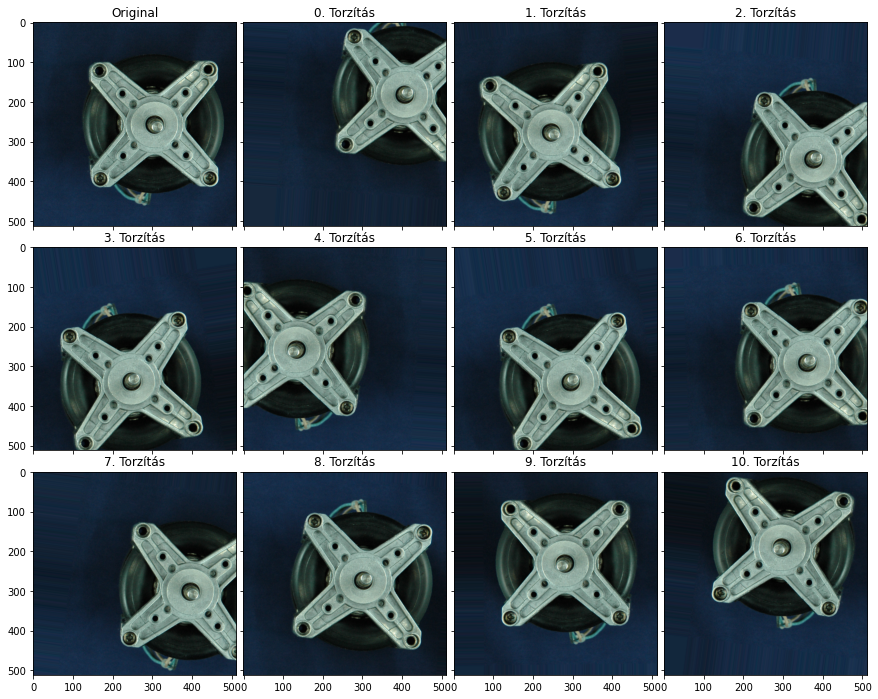

In [110]:
# Display the random augmentations
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(16, 12))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 4), axes_pad=(0.1, 0.3))
# grid: rács 
# fig: the parent figure
# 111: "rect" paraméter: a three-digit subplot position code (e.g., "121")
# axes_pad: hely a négyzetek között - (horizontal padding, vertical padding) between axes, in inches.


grid[0].imshow(features[random_index]) # itt mivel eredetileg is 1 képet vár (csak 3 dimenziós arrayt), ezért []-vel választjuk ki a features-ből ezt a képet
grid[0].set_title("Original")

for i, ax in enumerate(grid[1:]): # 0-11-ig vannak indexelve a négyzetek a grid-ben (mert 3x4-es), az első (0-s indexű) kihagyjuk, mert ott az eredeti képet jelenítjük meg 
    image = datagen.flow(features[[random_index]]).next()[0].astype(int) # így lehet 'batch of torzított képeket' generálni 1 képből, pontosabban minden iterációnál +1 torzított képet generál (szerintem), és ezt jeleníti meg egy sorral lejjebb a grid négyzetében (ax-ban)
                                                                         # bővebb infot itt találtam: https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/                                                                        
    ax.imshow(image) # Plot image
    #saját kiegészítés, címet adok a grid mindegyik négyzetének (ax-oknak)
    ax.set_title("{}. Torzítás".format(i))
    
plt.show()

In [127]:
### Run model training with given data generator

print(X_train.shape)
print(y_train.shape)

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, train_size=0.9, stratify=y_train, random_state=21)
# A korábban betöltött X és y training setek 10%-át validation set-re alakítjuk, ezen próbálgatjuk, teszteljük, validáljuk az augmentiációt
# A test set-t majd csak az evaluation-höz használjuk
# "Validation set is used to test our fit of the model and tune it’s hyperparameters"
# "Test set is used to evaluate the performance of the final version of our model"
print(X_train.shape) #49 10%-a 4.9, így 5-t választ le validation-nek a train-ből (44, 512, 512, 3)
print(len(X_train))
print(X_validation.shape)
print(y_train.shape) #49 10%-a 4.9, így 5-t választ le validation-nek a train-ből (44, 3)
print(y_validation.shape)
from keras.models import Sequential  #ezeket a libraryket azért importálom, mert ahol előzőleg importálva voltak, ott ezzel együtt a modellt is felépítettük, és nem célszerű újra felépíteni azokat a modelleket (pl eredményük tárolása miatt)
from keras.layers import Dense, Activation 
from keras.layers import Conv2D, Dense, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

datagen.fit(X_train) # Fitteljük az image generátort a már létező training képekre
# eredetileg: datagen.fit(np.array(X_train)) 
# array-jé alakítás azért van, mert a train_test_split eredetileg list-eket ad vissza, de a features, labels train és testre szétválasztása előtt már array-jé alakítottuk ezeket, így array-eket kaptunk vissza, ezekkel dolgozunk végig
# tehát felesleges az array-jé alakítás

# pontosan ilyen model struktúra még nem volt (layerek, azokon belül filterek és filter mátrixok mérete) 
model = Sequential()

model.add(Conv2D(8, 5,  input_shape = X_train[0].shape, activation = 'relu', padding="same")) # ebben a layerben 8 filter, 5x5-ös filter mátrixokkal (8 db)
model.add(MaxPooling2D())
print("# (512,512,3)-t várok a print outputba a képek betöltésekor megadott méret és Color=True miatt", X_train[0].shape) 

model.add(Conv2D(8, 5, activation = 'relu', padding="same"))
model.add(MaxPooling2D())

model.add(Conv2D(16, 5, activation = 'relu', padding="same"))
model.add(MaxPooling2D())

model.add(Conv2D(16, 3, activation = 'relu', padding="same"))
model.add(GlobalMaxPooling2D())

model.add(Dense(64, activation = 'relu'))
# Dense: Just your regular densely-connected NN layer. Dense implements the operation: output = activation(dot(input, kernel) + bias)
# 32: units paraméter, dimensionality of the output space - the model will output arrays of shape (None, 32). ((sample_szám, 32) formájú output array)
# Tehát ebben a Dense layerben ennyi (32) perceptron alakítja át a saját outputjává (y_i) ugyanazt az input képet (x1, x2, ..xn ből áll, mindegyik perceptron mindegyiket felhasználja)
# A perceptronok saját outputjai:  y_i outputja van: output_i = activation(dot(input x-ek, kernel_i) + bias_i), kernel_i az az adott perceptron saját weights-jei

model.add(Dense(16, activation = 'relu'))

model.add(Dense(y_train[0].shape[0], activation = 'softmax'))
print(y_train[0].shape[0]) #3-t várok a print outputba a label-k one hot encodingolt formája miatt


model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])


model.fit(datagen.flow((X_train), (y_train), batch_size=8), 
            validation_data=(X_validation, y_validation),
            steps_per_epoch=len(X_train) / 8, # = 44/8 = 5.5
            epochs=50)

# eddig, azaz data augmentation nélkül ez a model trainelés (model.fit) így nézett ki:
# model.fit(X_train, y_train, epochs = 75, batch_size = 32, validation_split=0.1, verbose = 1, sample_weight=compute_sample_weight('balanced', y_train))

# a mostani modell train-nél:
    # datagen.flow((X_train), (y_train), batch_size=8): the iterator for the train images that we get from the flow
        # tehát szerintem az augmentált képek iterátorja (iterátor, mert batch-onként fittel szerintem)
        # az y_train labeleket (one hot enc formátumúak) használja fel az augmentált képek labeljeként, azt nem tudom, hogy 1 db X_train képet hányszor augmentál (1x?)
        # ezen belül a batch size jelentése, hogy most nem egyszerre töltjük be az összes X_train képet, hanem batchokban, és egy ilyen batchba 8 képet töltünk be:
            # without using the ImageDataGenerator class, we load all the images at once. But on using it, we are loading the images in batches which saves a lot of memory.

    # validation_data=(X_validation, y_validation): takes the validation dataset
        # most nem csak az arányt adtuk meg, hogy fitteléskor mekkora részt különítsen el (a paraméterek finomításához) validation set-ként a training datasetből (validation_split=0.1 -gyel),
        # hanem konkrétran megadtuk, hogy mi a validation dataset x-ek (feature-k) és hozzájuk tartozó y-k (labelek) formájában

    # steps_per_epoch=len(X_train) / 8: an important argument. 
        # It specifies the number of batches of images that are in a single epoch. It is usually taken as the length of the original dataset divided by the batch size.
        # azért osztjuk a train dataset hosszát a batch_size-zal, hogy annyi darab batch-t kapjunk vissza, amennyivel egy epoch alatt az egész dataset bejárható
        # batch-k száma = steps per epoch
    # epochs = 50: number of forward/backward passes of the training data
        # viszont a batch-ok végén updateli a paramétereket a Gradient Descent-tel, ez csak azt határozza meg, hogy ugyanazon az adat részen hányszor menjen át a Gradinet D. (iterálások száma)

# np.array(X_train), np.array(y_train) -ből a az array-já alakítást megint kitöröltem, ugyanaz az ok miatt

(49, 512, 512, 3)
(49, 3)
(44, 512, 512, 3)
44
(5, 512, 512, 3)
(44, 3)
(5, 3)
# (512,512,3)-t várok a print outputba a képek betöltésekor megadott méret és Color=True miatt (512, 512, 3)
3
Epoch 1/50
5/5 [==============================] - 7s 1s/step - loss: 5.5038 - accuracy: 0.4545 - val_loss: 0.8841 - val_accuracy: 0.6000
Epoch 2/50
5/5 [==============================] - 6s 1s/step - loss: 2.6499 - accuracy: 0.4091 - val_loss: 1.3107 - val_accuracy: 0.6000
Epoch 3/50
5/5 [==============================] - 6s 1s/step - loss: 2.0321 - accuracy: 0.3409 - val_loss: 1.4817 - val_accuracy: 0.0000e+00
Epoch 4/50
5/5 [==============================] - 6s 1s/step - loss: 1.4272 - accuracy: 0.4091 - val_loss: 0.4076 - val_accuracy: 0.6000
Epoch 5/50
5/5 [==============================] - 6s 987ms/step - loss: 1.1424 - accuracy: 0.5909 - val_loss: 0.2146 - val_accuracy: 1.0000
Epoch 6/50
5/5 [==============================] - 6s 1s/step - loss: 0.8214 - accuracy: 0.7273 - val_loss: 0.3478 - va

1/1 [==============================] - 1s 563ms/step
               precision    recall  f1-score   support

     Complete       0.00      0.00      0.00         2
Missing cover       0.86      1.00      0.92         6
Missing screw       0.93      1.00      0.96        13

     accuracy                           0.90        21
    macro avg       0.60      0.67      0.63        21
 weighted avg       0.82      0.90      0.86        21

[7.0166984e-04 1.1876910e-02 9.8742139e-01] [0. 0. 1.]
[2.9926190e-05 3.7697583e-01 6.2299430e-01] [0. 0. 1.]
[0.00164053 0.71556467 0.28279486] [0. 1. 0.]
[1.9955849e-05 3.5866149e-02 9.6411383e-01] [0. 0. 1.]
[0.00756292 0.05741652 0.93502057] [0. 0. 1.]
[1.9284618e-05 8.5871788e-03 9.9139351e-01] [0. 0. 1.]
[6.2728049e-08 9.9984765e-01 1.5222347e-04] [0. 1. 0.]
[3.5140975e-04 5.0612774e-02 9.4903576e-01] [0. 0. 1.]
[1.6360071e-08 9.9977559e-01 2.2438086e-04] [0. 1. 0.]
[1.6197332e-04 3.4511551e-02 9.6532649e-01] [0. 0. 1.]
[6.9991916e-06 8.6331982e-0

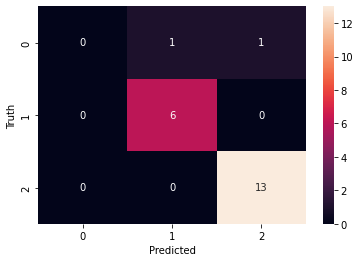

In [128]:
from sklearn.preprocessing import OneHotEncoder
evaluate_model(X_test, y_test, model)

Ez a modell teljesített a legjobban a data augmentationnek köszönhető több training data miatt,  összesen csak 2 hibás predict